In [1]:
%load_ext autoreload
%autoreload 2

from utils.prediction_models import *

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size': 15})
matplotlib.rcParams['figure.dpi'] = 200

In [3]:
DIR_data="/home/zeqianli/project/zeqian/Carbon/data"
zeqian=pd.read_pickle(f"{DIR_data}/zeqian/zeqian.pk")
matti=pd.read_pickle(f"{DIR_data}/matti/matti.pk")
bacdive=pd.read_pickle(f"{DIR_data}/bacdive/bacdive.pk")
datasets={"zeqian":zeqian,"matti":matti,"bacdive":bacdive,}

# Figure 1

See `figure_1.ipynb`. I have to seperate it to a different notebook to run on a different conda environment with older Python because of ete3 compatibility issue. 

# Figure 2

## 2A: Phylogeny models

In [4]:
# Zeqian 16S
from genomics_utils import IO
zeqian_sixteenS_data=IO.read_fasta(f"{DIR_data}/zeqian/zeqian_16S.aligned.fna",df=True)
zeqian_sixteenS_data=pd.DataFrame([list(s) for s in zeqian_sixteenS_data.seq],index=zeqian_sixteenS_data.id)
zeqian_sixteenS_data=zeqian_sixteenS_data.replace(['-','A','U','C','G'],[0,1,2,3,4])
zeqian_sixteenS_data.index=zeqian_sixteenS_data.index.str.replace('zeqian_','')
zeqian_sixteenS_data=zeqian_sixteenS_data.loc[zeqian['samples']]

matti_sixteenS_data=IO.read_fasta(f"{DIR_data}/matti/matti_16S.aligned.fna",df=True)
matti_sixteenS_data=pd.DataFrame([list(s) for s in matti_sixteenS_data.seq],index=matti_sixteenS_data.id)
matti_sixteenS_data=matti_sixteenS_data.replace(['-','A','U','C','G'],[0,1,2,3,4])
matti_sixteenS_data.index=matti_sixteenS_data.index.str.replace('matti_','')
matti_sixteenS_data=matti_sixteenS_data.loc[matti['samples']]

In [5]:
threads=48
p=None
#p=Pool(threads)

In [6]:
DIR_figure=f"{DIR_data}/figure_data/2A"


models={'fba':[FBAClassifier, # This will throw an error for Matti's data, but it will be automatically skipped. 
                {'model_params':{c: {'c':c,
                                'growth':"/home/zeqianli/project/zeqian/Carbon/data/zeqian/fba_concatenated/zeqian_fba.csv",
                                'growth_threshold':0.05} for c in CARBONS},
                'split_method':{c:[zeqian['growth_data'].index.values] for c in CARBONS},
                'threads': threads,
                'allow_empty_set':True,
                'save_models':False
                }
                ],
        # 'fba_gapfill':[FBAClassifier,
        #         {'model_params':{c: {'c':c,
        #                         'growth':"/home/zeqianli/project/zeqian/Carbon/data/zeqian/fba_concatenated/zeqian_fba_gapfill.csv",
        #                         'growth_threshold':0.05} for c in CARBONS},
        #         'split_method':{c:[zeqian['growth_data'].index.values] for c in CARBONS},
        #         'threads':threads,
        #         'allow_empty_set':True,
        #         'save_models':False
        #         }
        #         ],
        'null': [BernoulliNull,
                {'model_params':{},
                 'split_method':'random',
                 'splitter_params': {'test_set_ratio':0.2}, 
                 'n_splits':100,
                 'threads': 1,
                 'save_models':False
                 }],
        'identity_null': [IdentityNull,
                {'model_params':{},
                 'split_method':'random',
                 'splitter_params': {'test_set_ratio':0.2}, 
                 'n_splits':100,
                 'threads': 1,
                 'save_models':False
                 }],
        'NN':[NearestNeighbor,
                {'model_params':{'n_neighbors':1,'metric':'hamming'},
                'split_method':'random',
                 'splitter_params': {'test_set_ratio':0.2}, 
                 'n_splits':100,
                 'threads': threads,
                 'save_models':False
                 }
              ],

        'null_ooc': [BernoulliNull,
                {'model_params':{},
                 'split_method':'ooc',
                 'splitter_params': {'test_set_range':(0.1,0.3), 'min_zeros':0, 'min_ones':0, 'time_out_iter':None},
                 'n_splits':100,
                 'threads': 1,
                 'save_models':False
                 }],
        'identity_null_ooc': [IdentityNull,
                {'model_params':{},
                 'split_method':'ooc',
                 'splitter_params': {'test_set_range':(0.1,0.3), 'min_zeros':0, 'min_ones':0, 'time_out_iter':None},
                 'n_splits':100,
                 'threads': 1,
                 'save_models':False
                 }],
        'NN_ooc':[NearestNeighbor,
                {'model_params':{'n_neighbors':1,'metric':'hamming'},
                'split_method':'ooc',
                'splitter_params': {'test_set_range':(0.1,0.3), 'min_zeros':0, 'min_ones':0, 'time_out_iter':None},
                'n_splits':100,
                'threads': threads,
                'save_models':False
                }
                ],
        
}

matrices={'zeqian_16s': {'ko_data': zeqian_sixteenS_data, 'growth_data':zeqian['growth_data'],'carbons':zeqian['carbons'],'tree':zeqian['tree'],'samples':zeqian['samples']},
         'matti_16s': {'ko_data': matti_sixteenS_data, 'growth_data':matti['growth_data'],'carbons':matti['carbons'],'tree':matti['tree'],'samples':matti['samples']}}

In [7]:
results_all=run_multiple_models(models, matrices, DIR_figure,p=None)

Traceback (most recent call last):
  File "/home/zeqianli/Kuehn/Carbon/utils/prediction_models.py", line 1341, in run_multiple_models
    pipe=PredictionPipeline(Model, **params)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/zeqianli/Kuehn/Carbon/utils/prediction_models.py", line 1146, in __init__
    raise ValueError("A Pool object is required for multi-threading.")
ValueError: A Pool object is required for multi-threading.


Running models...
Running zeqian_16s fba
Already exists. Skipping. 
Running matti_16s fba
Failed to run matti_16s fba
Running zeqian_16s null
Changed to /home/zeqianli/project/zeqian/Carbon/data/figure_data/2A/cache/zeqian_16s_null_0.pk. 


Training models...: 100%|██████████| 1000/1000 [00:10<00:00, 92.08it/s]


Finished zeqian_16s null 
Running matti_16s null
Changed to /home/zeqianli/project/zeqian/Carbon/data/figure_data/2A/cache/matti_16s_null_0.pk. 


Training models...: 100%|██████████| 10000/10000 [04:43<00:00, 35.24it/s]


Finished matti_16s null 
Running zeqian_16s identity_null


Training models...: 100%|██████████| 1000/1000 [00:11<00:00, 88.57it/s]


Finished zeqian_16s identity_null 
Running matti_16s identity_null


Training models...: 100%|██████████| 10000/10000 [04:54<00:00, 33.99it/s]


Finished matti_16s identity_null 
Running zeqian_16s NN
Already exists. Skipping. 
Running matti_16s NN
Already exists. Skipping. 
Running zeqian_16s null_ooc
Changed to /home/zeqianli/project/zeqian/Carbon/data/figure_data/2A/cache/zeqian_16s_null_ooc_0.pk. 


Training models...: 100%|██████████| 1000/1000 [00:11<00:00, 88.01it/s]


Finished zeqian_16s null_ooc 
Running matti_16s null_ooc
Changed to /home/zeqianli/project/zeqian/Carbon/data/figure_data/2A/cache/matti_16s_null_ooc_0.pk. 


Training models...: 100%|██████████| 10000/10000 [04:49<00:00, 34.52it/s]


Finished matti_16s null_ooc 
Running zeqian_16s identity_null_ooc


Training models...: 100%|██████████| 1000/1000 [00:12<00:00, 78.11it/s]


Finished zeqian_16s identity_null_ooc 
Running matti_16s identity_null_ooc


Training models...: 100%|██████████| 10000/10000 [04:56<00:00, 33.69it/s]


Finished matti_16s identity_null_ooc 
Running zeqian_16s NN_ooc
Already exists. Skipping. 
Running matti_16s NN_ooc
Already exists. Skipping. 
Running models done.
Concatenating data...
[Errno 2] No such file or directory: '/home/zeqianli/project/zeqian/Carbon/data/figure_data/2A/results/matti_16s_fba.pk'
Failed to load matti_16s fba
Concatenating data done.


In [4]:
results_all=pd.read_pickle("/home/zeqianli/project/zeqian/Carbon/data/figure_data/2A/results_all.pk")
results_all=results_all[results_all['dataset_name']=='zeqian_16s']

model_pairs=[('fba', 'null'),  ('NN', 'null'), ('NN_ooc', 'null_ooc'),('fba', 'identity_null'),  ('NN', 'identity_null'), ('NN_ooc', 'identity_null_ooc')]
stats=compare_models(results_all, 
                    model_pairs=[('fba', 'null',one_sample_test), ('NN', 'null',ttest_permutation), ('NN_ooc', 'null_ooc',ttest_permutation),('fba', 'identity_null',one_sample_test), ('NN', 'identity_null',ttest_permutation), ('NN_ooc', 'identity_null_ooc',ttest_permutation)],
                    seperate_by='carbon_name',
                    model_key='model',
                    metric='accuracy',
                    p_threshold=0.05,
                    multi_testing_correction='hs',correct_by='carbons').set_index('carbon_name')

100%|██████████| 10/10 [00:32<00:00,  3.22s/it]

Correcting p-values...


/home/zeqianli/scratch-midway3/miniconda3/envs/zeqian/lib/python3.11/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


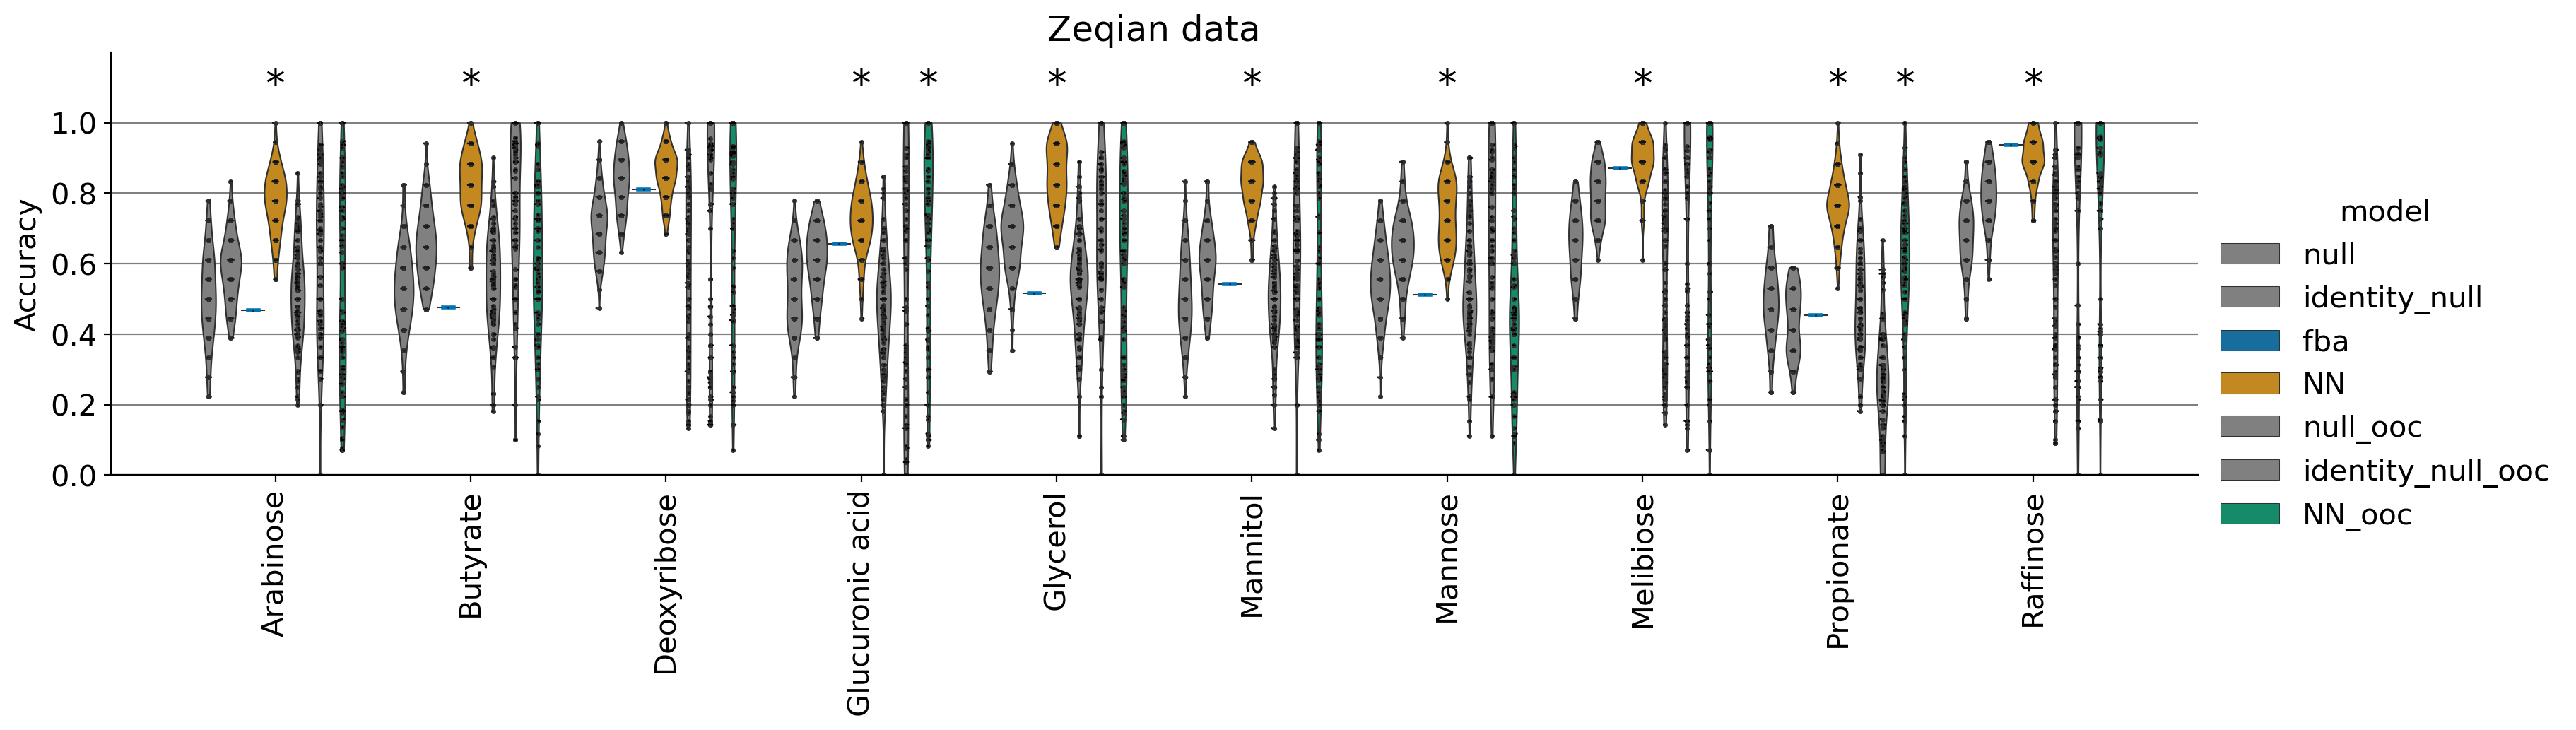

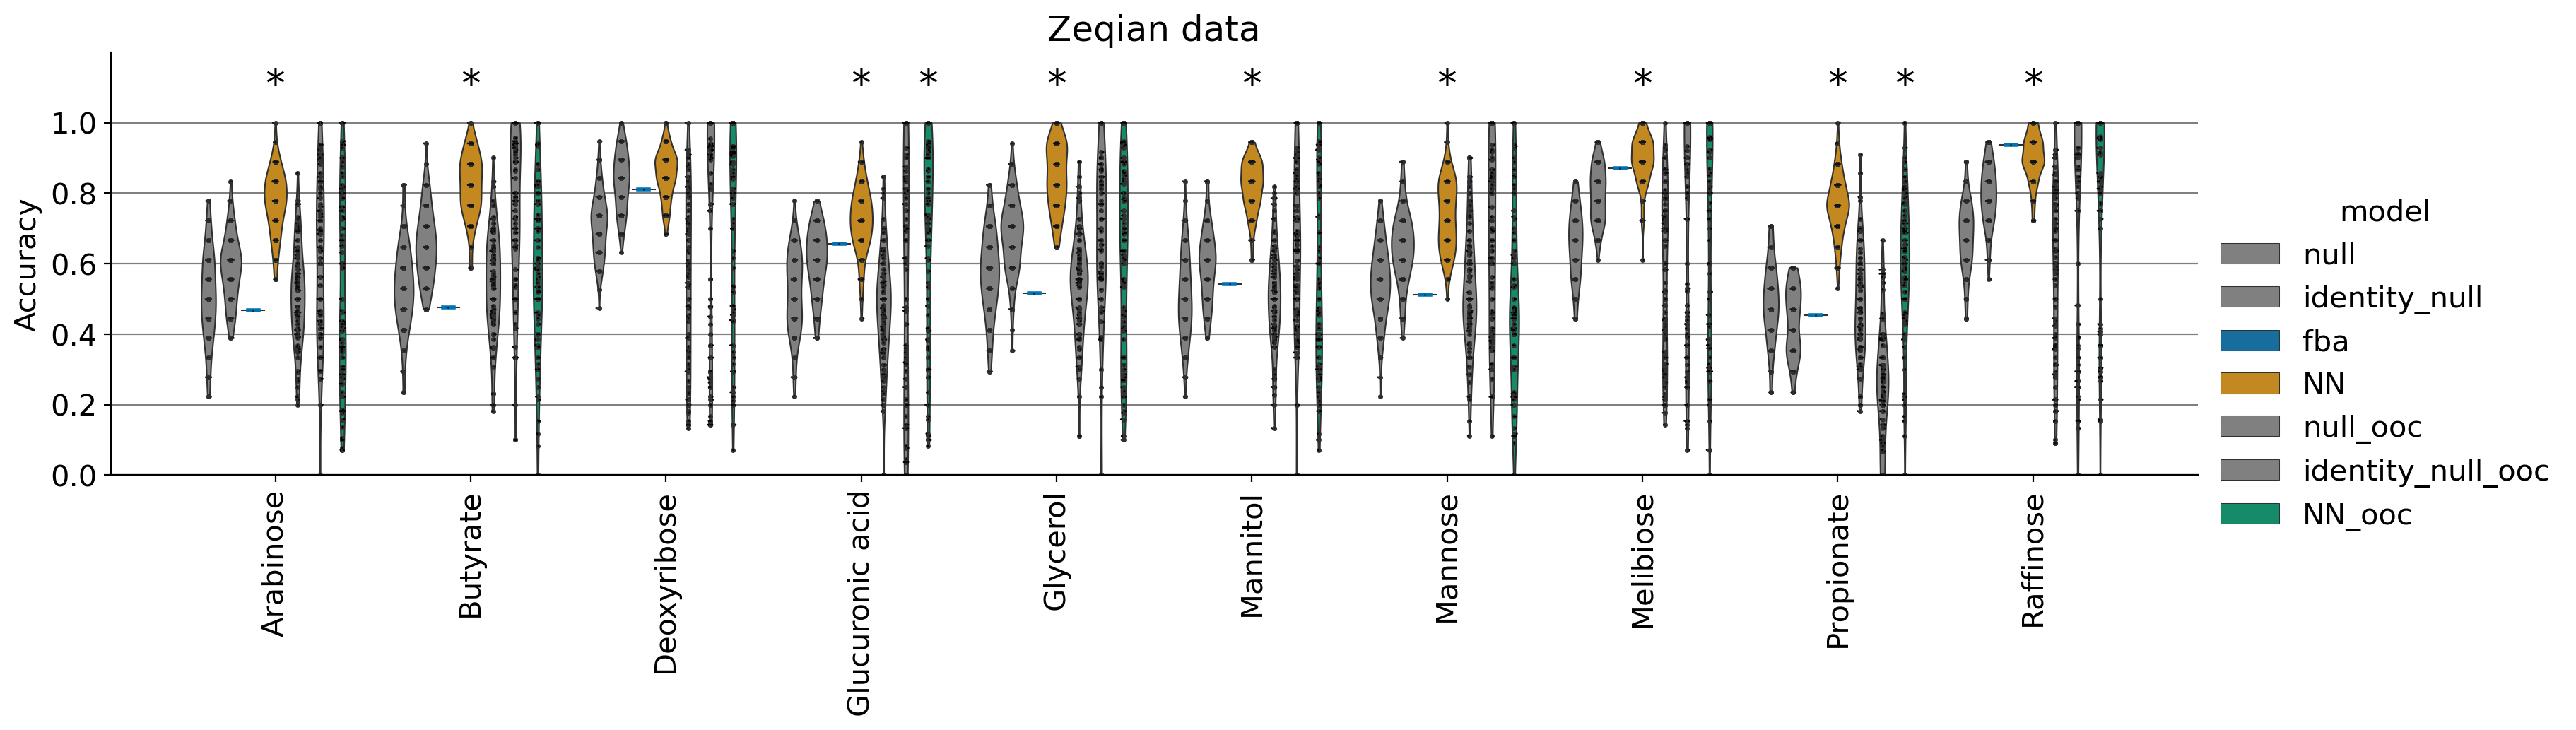

In [8]:
hue_order=['null', 'identity_null','fba', 'NN', 'null_ooc','identity_null_ooc','NN_ooc']

fig, stats=plot_fancy_model_comparison(results_all, hue_order=hue_order,stats=stats, model_pairs=model_pairs, multi_testing_correction=False, height=4, aspect=4,rotate_x=True, 
            single_annotation=True, show_null_model=True, pair_annotation=False, )
fig.gca().set_title(f"Zeqian data")
plt.ylabel('Accuracy')
plt.xlabel(None)
fig

In [9]:
# hue_order=['null', 'identity_null','fba', 'NN', 'null_ooc','identity_null_ooc','NN_ooc']

# fig, stats=plot_fancy_model_comparison(results_all, hue_order=hue_order,stats=stats, model_pairs=model_pairs, multi_testing_correction=False, height=4, aspect=4,rotate_x=True)
# fig.gca().set_title(f"Zeqian data")
# plt.ylabel('Accuracy')
# plt.xlabel(None)
# fig

## 2B: Phylogeny - trait correlation plot

See figure_2B.ipynb 

## 2C: External data sets

### Matti

In [11]:
results_all=pd.read_pickle("/home/zeqianli/project/zeqian/Carbon/data/figure_data/2A/results_all.pk")
results_all=results_all[results_all['dataset_name']=='matti_16s']

model_pairs=[('NN', 'null'), ('NN_ooc', 'null_ooc'),('NN', 'identity_null'), ('NN_ooc', 'identity_null_ooc')]
# hue_order=['null', 'fba', 'NN', 'null_ooc','NN_ooc']
stats=compare_models(results_all, 
                    model_pairs=[('NN', 'null',ttest_permutation), ('NN_ooc', 'null_ooc',ttest_permutation),('NN', 'identity_null',ttest_permutation), ('NN_ooc', 'identity_null_ooc',ttest_permutation)],
                    seperate_by='carbon_name',
                    model_key='model',
                    metric='accuracy',
                    p_threshold=0.05,
                    multi_testing_correction='hs',correct_by='carbons').set_index('carbon_name')

100%|██████████| 100/100 [05:22<00:00,  3.23s/it]

Correcting p-values...


In [12]:
stats.to_pickle("/home/zeqianli/project/zeqian/Carbon/data/figure_data/2C/matti_stats.pk")

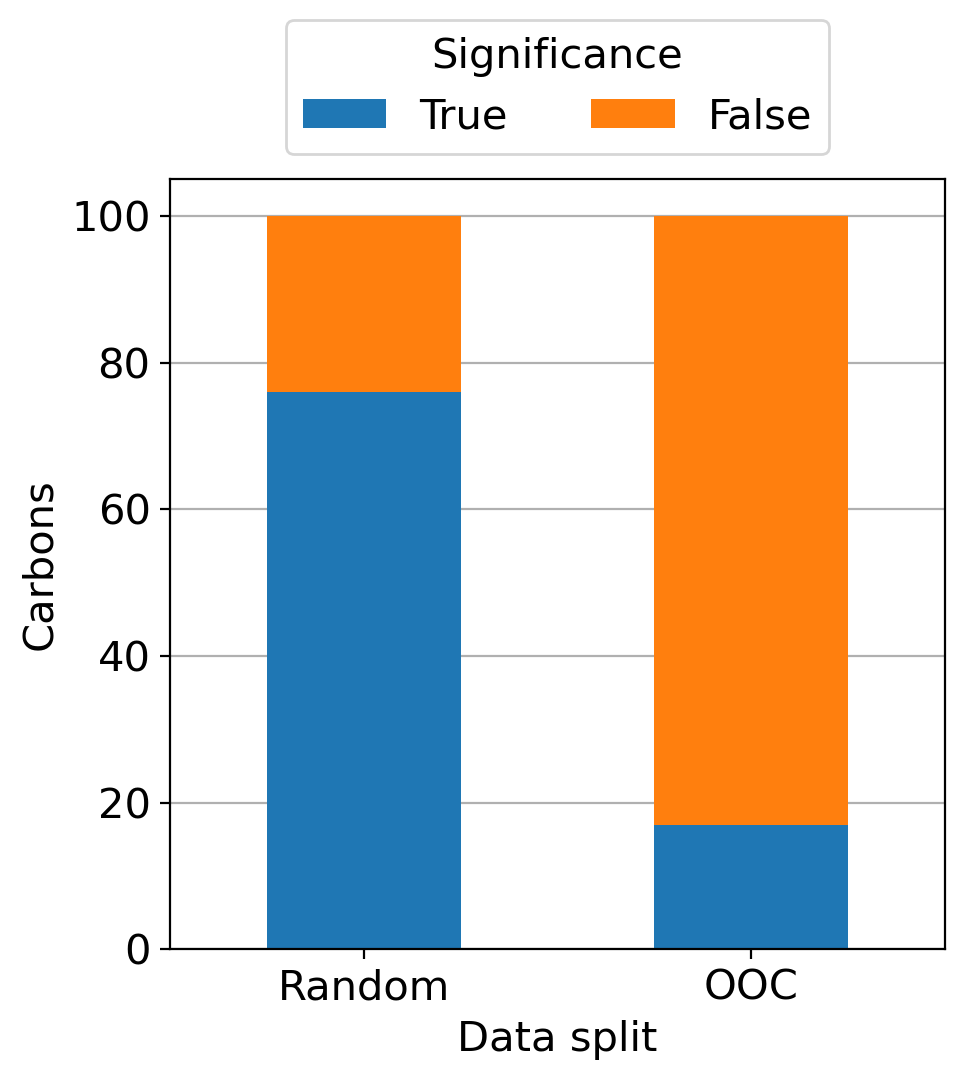

In [46]:
stats=pd.read_pickle("/home/zeqianli/project/zeqian/Carbon/data/figure_data/2C/matti_stats.pk")

stats['random_sig']=((stats['NN_null_p']<0.05) & (stats['NN_identity_null_p']<0.05) & (stats['NN_null_t']>0) & (stats['NN_identity_null_t']>0))
stats['ooc_sig']=((stats['NN_ooc_null_ooc_p']<0.05) & (stats['NN_ooc_identity_null_ooc_p']<0.05) & (stats['NN_ooc_null_ooc_t']>0) & (stats['NN_ooc_identity_null_ooc_t']>0))

plt.figure(figsize=(5,5))
df=stats[['random_sig','ooc_sig']].apply(lambda x:x.value_counts(),axis=0)
df.index=df.index.astype(str)
df=df.loc[['True','False'],:]
df.T.plot.bar(stacked=True,ax=plt.gca())

# legend to the right
# legend to bottom, 1 row
plt.legend(bbox_to_anchor=(0.5, 1.12), loc='center', title='Significance',borderaxespad=0.,ncol=2)

plt.xticks(ticks=plt.xticks()[0], labels=['Random','OOC'], rotation=0)
plt.ylabel("Carbons")
plt.xlabel("Data split")

# y grid
plt.gca().yaxis.grid(True)



### BacDive

Must use pre-calculated distances due to the large dataset size. 

In [ ]:
class NearestNeighborPrecalculated(BinaryGrowthClassifier):
    def __init__(self, dist_mat, n_neighbors=1, **kwargs):
        self.dist_mat=dist_mat
        self.model = KNeighborsClassifier(n_neighbors=n_neighbors, metric='precomputed', **kwargs)

    def fit(self, X, y):
        self.dist_mat=self.dist_mat.loc[y.index.values,:].loc[:, y.index.values]
        self.model.fit(self.dist_mat, y)
        return self

    def predict(self, X):
        return self.model.predict(X.index.values.reshape(-1,1))

    def get_params(self, deep=True):
        return {'n_neighbors': self.model.n_neighbors,
                'weights': self.model.weights,
                'metric': self.model.effective_metric_}
    

In [ ]:
bacdive_dist_mat=pd.read_pickle("/home/zeqianli/project/zeqian/Carbon/data/figure_data/2B/bacdive_dist_matrix.pk")

In [ ]:
DIR_figure=f"{DIR_data}/figure_data/2C"


models={
        'null': [BernoulliNull,
                {'model_params':{},
                 'split_method':'random',
                 'splitter_params': {'test_set_ratio':0.2}, 
                 'n_splits':threads,
                 'threads': threads,
                 'save_models':False
                 }],
        'NN':[NearestNeighborPrecalculated,
                {'model_params':{'n_neighbors':1,'dist_mat':bacdive_dist_mat},
                'split_method':'random',
                 'splitter_params': {'test_set_ratio':0.2}, 
                 'n_splits':100,
                 'threads': threads,
                 'save_models':False
                 }
              ],
        'null_ooc': [BernoulliNull,
                {'model_params':{},
                 'split_method':'ooc',
                 'splitter_params': {'test_set_range':(0.1,0.3), 'min_zeros':0, 'min_ones':0, 'time_out_iter':None},
                 'n_splits':100,
                 'threads': threads,
                 'save_models':False
                 }],
        'NN_ooc':[NearestNeighborPrecalculated,
                {'model_params':{'n_neighbors':1,'dist_mat':bacdive_dist_mat},
                'split_method':'ooc',
                'splitter_params': {'test_set_range':(0.1,0.3), 'min_zeros':0, 'min_ones':0, 'time_out_iter':None},
                'n_splits':100,
                'threads': threads,
                'save_models':False
                }
                ],
        
}

matrices={'bacdive_16s': bacdive}

In [ ]:
# BacDive
ko_data, growth_data, tree,carbons=bacdive['ko_data'],bacdive['growth_data'],bacdive['tree'],bacdive['carbons']
results_all=[]

#TODO: 16S for bacdive is too large. Need to use the pre-calcualted distance matrix for bacdive. Do this later. 

In [ ]:
# Run this cell for multithreading. Recycle the same Pool. Do not open multiple pools. 
threads=48
p=Pool(threads)

In [ ]:
DIR_figure=f"{DIR_data}/figure_data/2B"
models={
        # 'fba':[FBAClassifier,
        #         {'model_params':{c: {'c':c,
        #                         'growth':"/home/zeqianli/project/zeqian/Carbon/data/zeqian/fba_concatenated/zeqian_fba.csv",
        #                         'growth_threshold':0.05} for c in CARBONS},
        #         'split_method':{c:[growth_data.index.values] for c in CARBONS},
        #         'threads':1,
        #         'allow_empty_set':True,
        #         'save_models':False
        #         }
        #         ],
        # 'fba_gapfill':[FBAClassifier,
        #         {'model_params':{c: {'c':c,
        #                         'growth':"/home/zeqianli/project/zeqian/Carbon/data/zeqian/fba_concatenated/zeqian_fba_gapfill.csv",
        #                         'growth_threshold':0.05} for c in CARBONS},
        #         'split_method':{c:[growth_data.index.values] for c in CARBONS},
        #         'threads':1,
        #         'allow_empty_set':True,
        #         'save_models':False
        #         }
        #         ],
        'null': [BernoulliNull,
                {'model_params':{},
                 'split_method':'random',
                 'splitter_params': {'test_set_ratio':0.2}, 
                 'n_splits':100,
                 'threads': threads,
                 'p':p,
                 'save_models':False,
                 'carbons':carbons,
                 }],
        'null_ooc': [BernoulliNull,
                {'model_params':{},
                 'split_method':'ooc',
                 'splitter_params': {'test_set_range':(0.1,0.3), 'min_zeros':0, 'min_ones':0, 'time_out_iter':None},
                 'n_splits':100,
                 'threads': threads,
                 'tree':bacdive['tree'],
                 'p':p,
                 'save_models':False,
                 'carbons':carbons
                 }],
                
        'NN':[NearestNeighbor,
                {'model_params':{'n_neighbors':1,'metric':'hamming'},
                'split_method':'random',
                 'splitter_params': {'test_set_ratio':0.2}, 
                 'n_splits':100,
                 'threads': threads,
                 'p':p,
                 'save_models':False,
                 'carbons':carbons
                 }
              ],
        'NN_ooc':[NearestNeighbor,
                {'model_params':{'n_neighbors':1,'metric':'hamming'},
                'split_method':'ooc',
                'splitter_params': {'test_set_range':(0.1,0.3), 'min_zeros':0, 'min_ones':0, 'time_out_iter':None},
                'n_splits':100,
                'threads': threads,
                'tree':bacdive['tree'],
                'p':p,
                'save_models':False,
                'carbons':carbons
                }
                ]
}

matrices={ 
        # 'matti_16s': [sixteenS_data,growth_data],
          'bacdive_genome': [ko_data,growth_data]
        }


In [ ]:
results_all.to_pickle(f"{DIR_data}/figure_data/2B/bacdive_results_all.pk")

In [ ]:
# p-value

results_all=pd.read_pickle(f"{DIR_data}/figure_data/2B/bacdive_results_all.pk")
stat=compare_models(results_all[results_all['dataset_name']=='bacdive_genome'], 
                    model_pairs=[
                        # (('fba','null'),one_sample_test),
                        # (('fba_gapfill','null'),one_sample_test),
                        (('NN','null'),ttest),
                        (('NN_ooc','null_ooc'),ttest)
                    ],
                    seperate_by='carbon_name',
                    model_key='model',
                    metric='accuracy')

stat.to_pickle(f"{DIR_data}/figure_data/2B/bacdive_stat.pk")

TODO: I don't know why this figure looks insane. Probably because of rare carbons. Filter the carbons with enough sampels in the future. 

# Figure 3

## 3A: models 

Left: Null, FBA, NN-genomes, NN-RF, NN-OOC, feature selection

Right: FI

In [47]:
threads=48
p=None
#p=Pool(threads)

In [48]:
DIR_figure=f"{DIR_data}/figure_data/3A"


models={'null': [BernoulliNull,
                {'model_params':{},
                 'split_method':'random',
                 'splitter_params': {'test_set_ratio':0.2}, 
                 'n_splits':100,
                 'threads': threads,
                 'save_models':False
                 }],
        'null_ooc': [BernoulliNull,
                {'model_params':{},
                 'split_method':'ooc',
                 'splitter_params': {'test_set_range':(0.1,0.3), 'min_zeros':0, 'min_ones':0, 'time_out_iter':None},
                 'n_splits':100,
                 'threads': threads,
                 'save_models':False
                 }],
        'identity_null': [IdentityNull,
                {'model_params':{},
                 'split_method':'random',
                 'splitter_params': {'test_set_ratio':0.2}, 
                 'n_splits':100,
                 'threads': 1,
                 'save_models':False
                 }],
        'identity_null_ooc': [IdentityNull,
                {'model_params':{},
                 'split_method':'ooc',
                 'splitter_params': {'test_set_range':(0.1,0.3), 'min_zeros':0, 'min_ones':0, 'time_out_iter':None},
                 'n_splits':100,
                 'threads': 1,
                 'save_models':False
                 }],
                
        'NN':[NearestNeighbor,
                {'model_params':{'n_neighbors':1,'metric':'hamming'},
                'split_method':'random',
                 'splitter_params': {'test_set_ratio':0.2}, 
                 'n_splits':100,
                 'threads': threads,
                 'save_models':False
                 }
              ],
        'NN_ooc':[NearestNeighbor,
                {'model_params':{'n_neighbors':1,'metric':'hamming'},
                'split_method':'ooc',
                'splitter_params': {'test_set_range':(0.1,0.3), 'min_zeros':0, 'min_ones':0, 'time_out_iter':None},
                'n_splits':100,
                'threads': threads,
                'save_models':False
                }
                ],
        'RF':[RF,
                {'model_params':{'n_estimators':100,'max_depth':None, 'max_features': None},
                 'split_method':'random',
                 'splitter_params': {'test_set_ratio':0.2}, 
                 'n_splits':100,
                 'threads': threads,
                 'save_models':False
                },
        ],
        'RF_ooc':[RF,
                {'model_params':{'n_estimators':100,'max_depth':None, 'max_features': None},
                'split_method':'ooc',   
                'splitter_params': {'test_set_range':(0.1,0.3), 'min_zeros':0, 'min_ones':0, 'time_out_iter':None},
                'n_splits':100,
                'threads': threads,
                'save_models':False
                }],
        'GreedyFeatureSelection_ooc':[GreedyFeatureSelection,
                {'model_params':{
                    "Model":DecisionTree, 
                    'tree':zeqian['tree'],
                    "model_params":{},
                    "n_max_features":3, 
                    "n_feature_subsample":None,
                    "n_meta_split":10, 
                    "split_method":'ooc',
                    "splitter_params":{'test_set_range':(0.1,0.3),'min_zeros':0,'min_ones':0,'time_out_iter':None},
                    "threads":threads,                    
                    "save_meta_models":False,
                    'verbose':False,
                    'p':p,},
                'split_method':'ooc',
                'splitter_params': {'test_set_range':(0.1,0.3), 'min_zeros':0, 'min_ones':0, 'time_out_iter':None},
                'n_splits':10,
                'threads':1,
                'save_models':False,
                }]
}

matrices={
          'zeqian_genome': zeqian
        }


In [49]:
results_all=run_multiple_models(models, matrices, DIR_figure, 
                    p=None)

Running models...
Running zeqian_genome null
Already exists. Skipping. 
Running zeqian_genome null_ooc
Already exists. Skipping. 
Running zeqian_genome identity_null


Training models...: 100%|██████████| 1000/1000 [00:02<00:00, 428.66it/s]


Finished zeqian_genome identity_null 
Running zeqian_genome identity_null_ooc


Training models...: 100%|██████████| 1000/1000 [00:02<00:00, 416.43it/s]


Finished zeqian_genome identity_null_ooc 
Running zeqian_genome NN
Already exists. Skipping. 
Running zeqian_genome NN_ooc
Already exists. Skipping. 
Running zeqian_genome RF
Already exists. Skipping. 
Running zeqian_genome RF_ooc
Already exists. Skipping. 
Running zeqian_genome GreedyFeatureSelection
Already exists. Skipping. 
Running models done.
Concatenating data...
Concatenating data done.


In [11]:
results_all=pd.read_pickle("/home/zeqianli/project/zeqian/Carbon/data/figure_data/3A/results_all.pk")

results_all['model']=results_all['model'].replace({'GreedyFeatureSelection':'GreedyFeatureSelection_ooc'})

In [12]:
model_pairs=[('NN', 'null'), ('NN_ooc', 'null_ooc'), ('RF', 'null'), ('RF_ooc', 'null_ooc'), ('GreedyFeatureSelection_ooc', 'null_ooc'),
            ('NN','identity_null'), ('NN_ooc','identity_null_ooc'), ('RF','identity_null'), ('RF_ooc','identity_null_ooc'), ('GreedyFeatureSelection_ooc','identity_null_ooc')]
hue_order=['null', 'identity_null','RF', 'NN', 'null_ooc', 'identity_null_ooc','RF_ooc','NN_ooc','GreedyFeatureSelection_ooc']
stats=compare_models(results_all, 
                    model_pairs=[
                        (*model_pair, ttest_permutation) for model_pair in model_pairs
                    ],
                    seperate_by='carbon_name',
                    model_key='model',
                    metric='accuracy',
                    p_threshold=0.05,
                    multi_testing_correction=False).set_index('carbon_name')

 70%|███████   | 7/10 [00:53<00:23,  7.71s/it]/home/zeqianli/scratch-midway3/miniconda3/envs/zeqian/lib/python3.11/site-packages/scipy/stats/_stats_py.py:6693: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat.append(_calc_t_stat(a, b, equal_var))
100%|██████████| 10/10 [01:17<00:00,  7.71s/it]


In [55]:
stats

stat,GreedyFeatureSelection_identity_null_ooc_p,GreedyFeatureSelection_identity_null_ooc_t,GreedyFeatureSelection_null_ooc_p,GreedyFeatureSelection_null_ooc_t,NN_identity_null_p,NN_identity_null_t,NN_null_p,NN_null_t,NN_ooc_identity_null_ooc_p,NN_ooc_identity_null_ooc_t,NN_ooc_null_ooc_p,NN_ooc_null_ooc_t,RF_identity_null_p,RF_identity_null_t,RF_null_p,RF_null_t,RF_ooc_identity_null_ooc_p,RF_ooc_identity_null_ooc_t,RF_ooc_null_ooc_p,RF_ooc_null_ooc_t
carbon_name,,,,,,,,,,,,,,,,,,,,
Arabinose,0.974250,0.031264,0.237208,1.261613,0.00001,19.211522,0.00001,25.289638,0.173478,-1.371103,0.054549,1.932138,0.00001,20.537828,0.00001,26.819006,0.000040,-4.322105,0.165598,-1.387961
Butyrate,0.012430,-3.701171,0.007960,3.227374,0.00001,19.164852,0.00001,27.383880,0.000040,-4.562498,0.000010,4.892237,0.00001,17.214470,0.00001,25.137671,0.270337,1.103093,0.000010,14.750421
Deoxyribose,0.641484,0.471950,0.046720,2.269045,0.00001,9.296718,0.00001,21.062009,0.348937,0.936824,0.000010,5.648736,0.00001,11.365409,0.00001,23.446336,0.980090,0.024642,0.000040,4.382740
Glucuronic acid,0.555434,0.594707,0.202988,1.363713,0.00001,24.034431,0.00001,30.143945,0.248668,1.163017,0.000370,3.658712,0.00001,22.507097,0.00001,28.694342,0.318567,0.996382,0.000420,3.590340
Glycerol,0.047640,-2.378704,0.312917,-1.070641,0.00001,9.611329,0.00001,19.560498,0.481255,-0.704721,0.000110,3.893692,0.00001,14.734547,0.00001,25.690790,0.020670,-2.339345,0.030920,2.164879
Mannitol,0.471085,0.738640,0.127109,1.662872,0.00001,24.167399,0.00001,31.290946,0.966670,0.041958,0.019980,2.351039,0.00001,28.356478,0.00001,35.575609,0.003370,-2.970661,0.132549,-1.512858
Mannose,0.337547,-0.989046,0.930971,0.088961,0.00001,15.027940,0.00001,20.455179,0.009200,-2.634812,0.985170,0.018748,0.00001,17.600810,0.00001,22.971785,0.000330,-3.725188,0.193008,-1.310796
Melibiose,0.236818,1.235359,0.061419,2.132821,0.00001,17.301943,0.00001,27.851259,0.633704,0.476285,0.014790,2.456439,0.00001,17.603271,0.00001,27.893206,0.483825,0.702820,0.007660,2.703768
Propionate,0.000800,4.765950,0.047510,2.206393,0.00001,33.999447,0.00001,23.845928,0.000010,10.788537,0.000010,5.418050,0.00001,31.805724,0.00001,21.545800,0.000010,15.958460,0.000010,10.108022


/home/zeqianli/scratch-midway3/miniconda3/envs/zeqian/lib/python3.11/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


Text(0.5, 85.99999999999994, '')

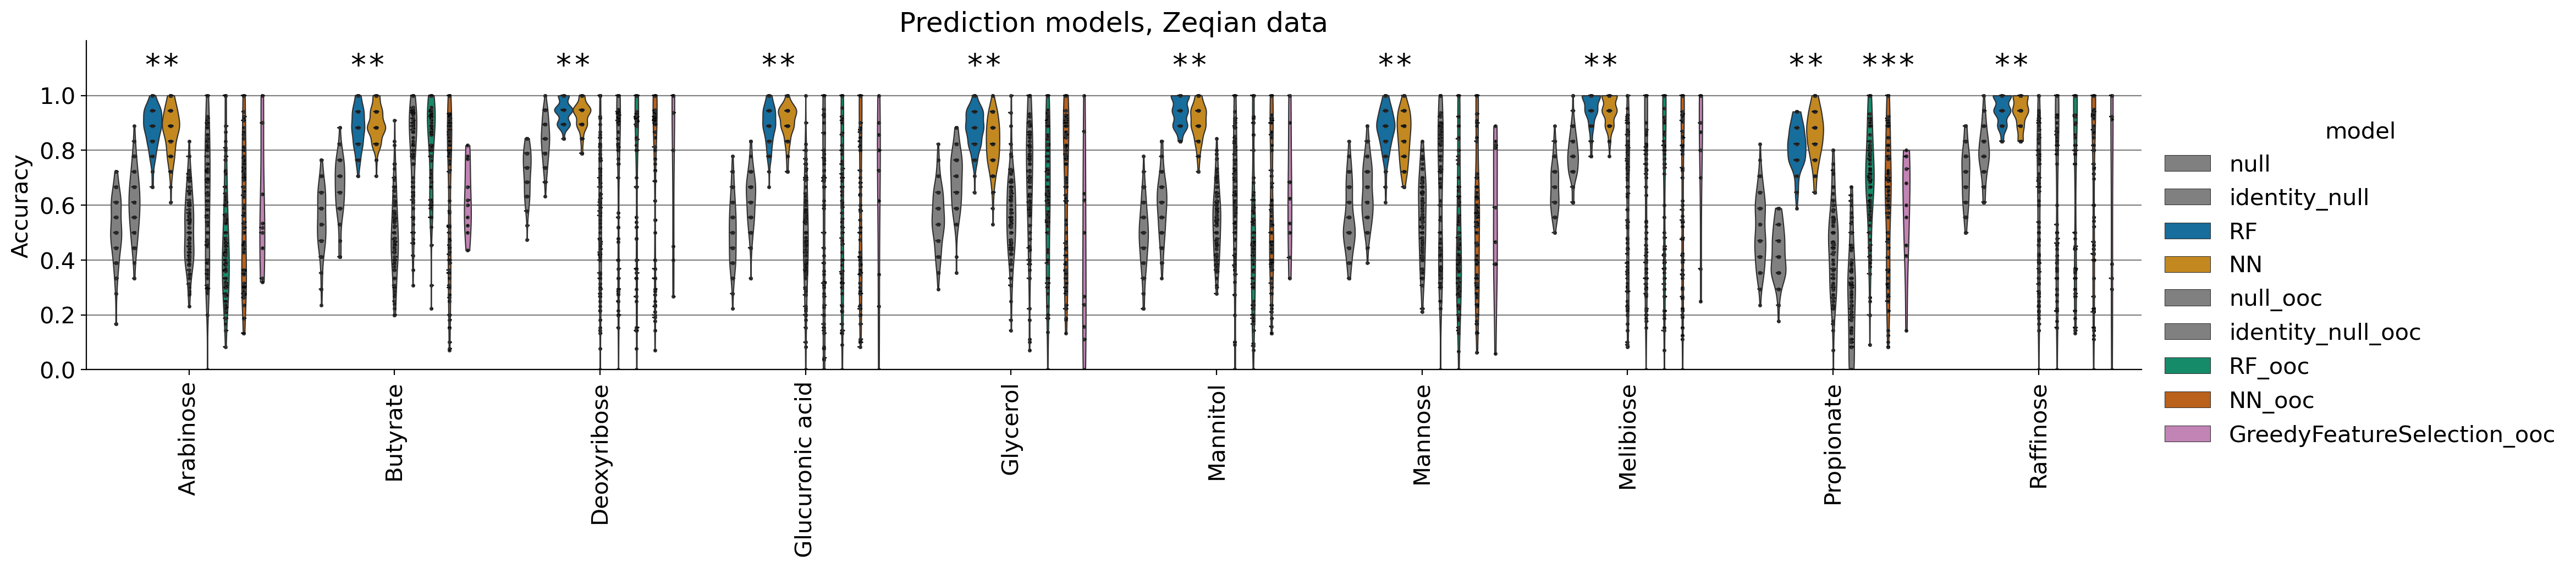

In [14]:
fig, stats=plot_fancy_model_comparison(results_all, hue_order=hue_order,stats=stats, model_pairs=model_pairs, multi_testing_correction=False, height=4, aspect=5,single_annotation=True, show_null_model=True, pair_annotation=False, )
fig.gca().set_title(f"Prediction models, Zeqian data")
plt.ylabel('Accuracy')
plt.xlabel(None)


TODO: just add an asterisk to the top of the violin. Don't use stat annotation. 

Also, seperate? 

### Feature importance

In [59]:
results_all=pd.read_pickle(f"{DIR_data}/figure_data/3A/zeqian_results_all.pk")

carbon_kos=[]
DIR_kegg_pathway="/home/zeqianli/project/zeqian/Carbon/data/kegg/pathways"
for pathway in os.listdir(DIR_kegg_pathway):
    carbon_kos.extend(pd.read_csv(os.path.join(DIR_kegg_pathway,pathway,'kos.txt'),sep='\t',header=None).values)
carbon_kos=np.unique(carbon_kos)

df_kegg=pd.read_pickle("/home/zeqianli/project/zeqian/Carbon/data/kegg/zeqian_kos_by_kegg.pk")
highlight_keys=['by_pathway','by_k3_path_directed','by_reaction']
highlight_dict={}
for c, row in df_kegg.iterrows():
    highlight_dict[c]={'carbon_metabolism': carbon_kos}
    for key in highlight_keys:
        highlight_dict[c][key]=row[key]



/home/zeqianli/ipykernel_3915207/2770526168.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


Text(0, 0.5, 'Mean feature importance')

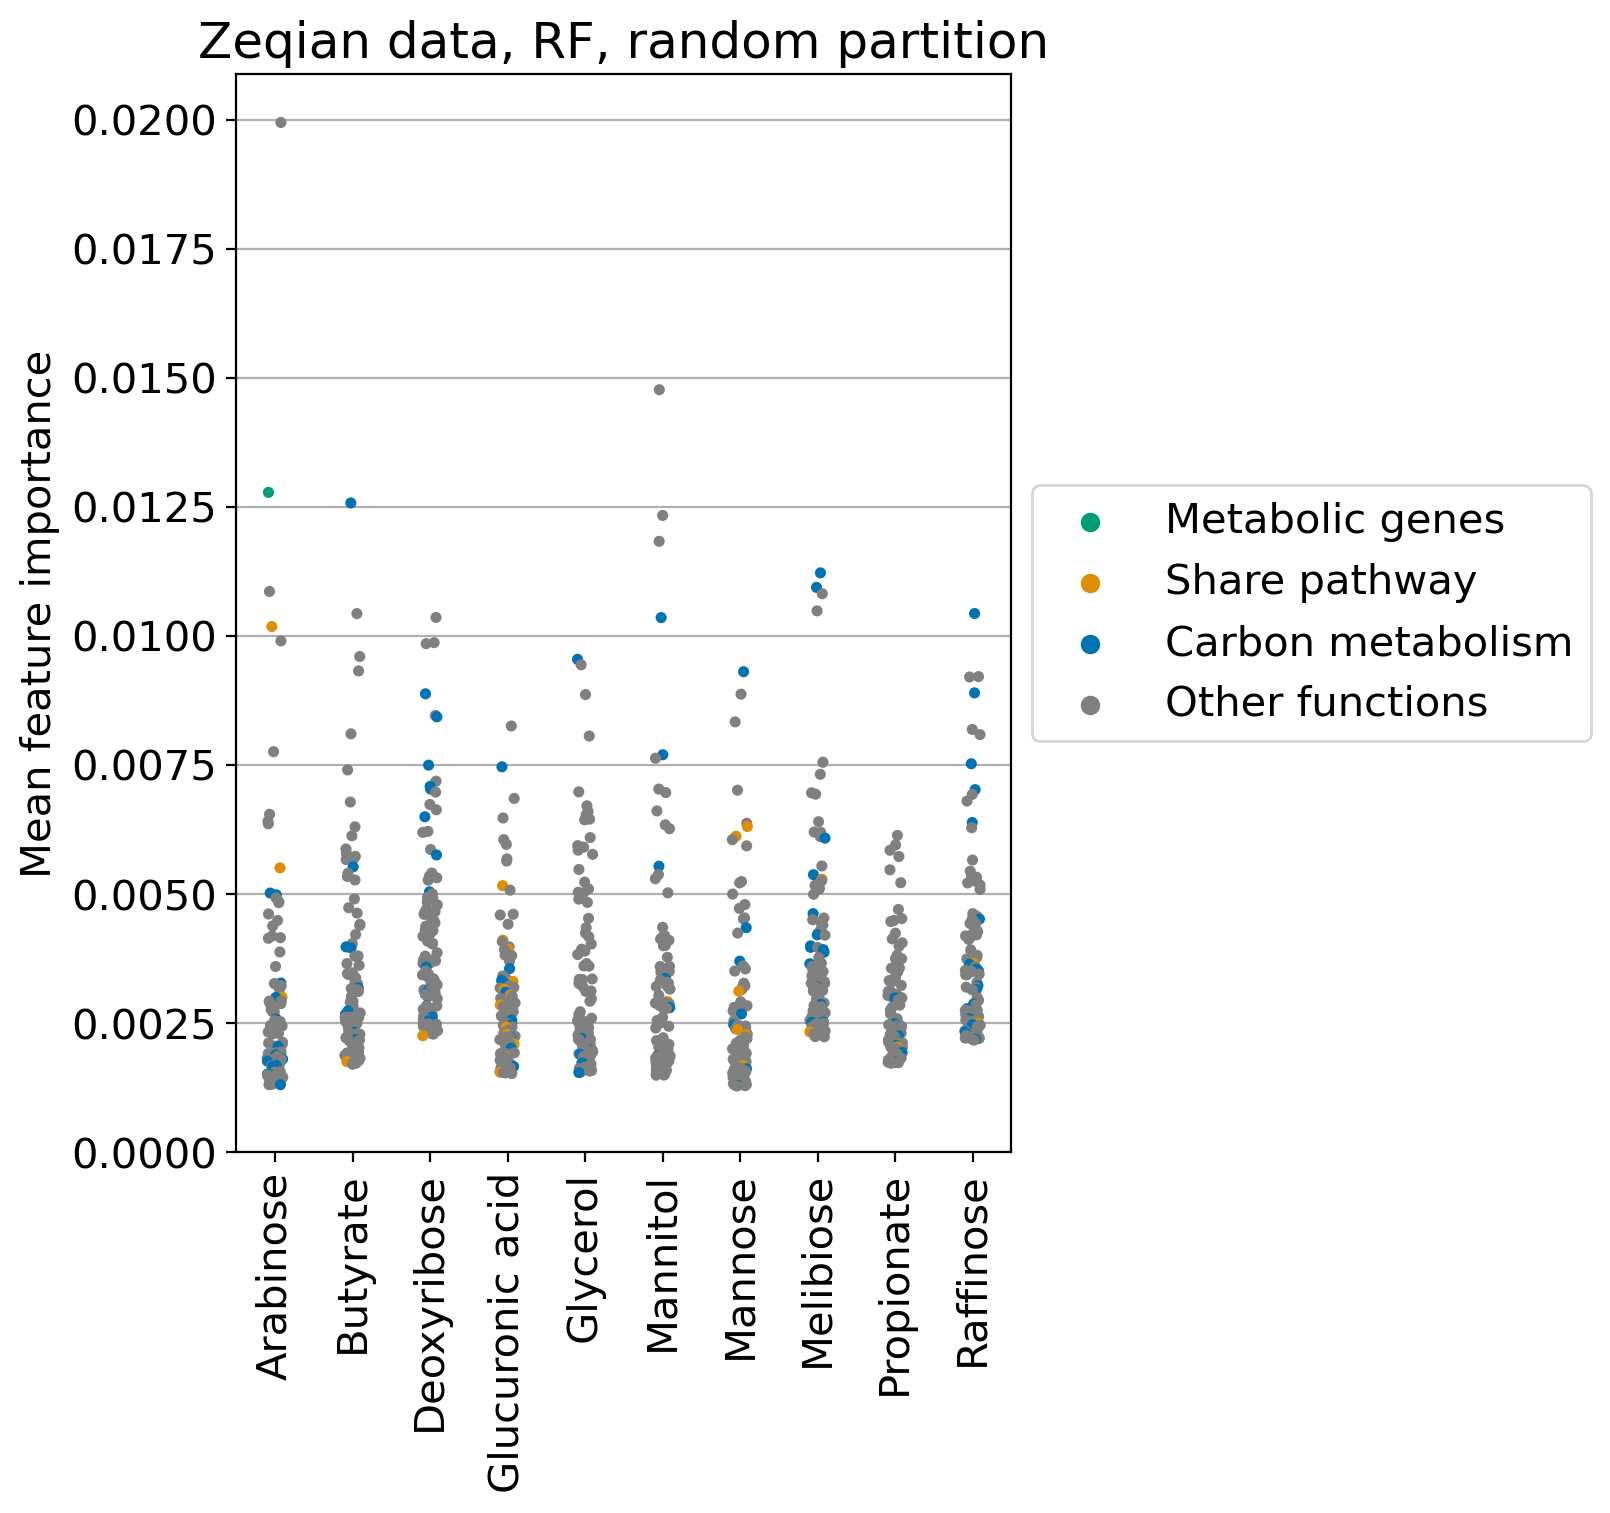

In [72]:
fi=cal_feature_importance(results_all[results_all['model']=='RF'], zeqian['ko_data'],highlight=highlight_dict,trim=100)
fi['highlight']=fi['highlight'].map({'':'Other functions','carbon_metabolism': 'Carbon metabolism', 'by_pathway': "Share pathway", 'by_k3_path_directed': "Metabolic genes"})
colors={'Other functions':'grey','Carbon metabolism':COLORS[0], 'Share pathway':COLORS[1], 'Metabolic genes':COLORS[2]}

plt.figure(figsize=(5,7))
sns.stripplot(data=fi, x='carbon_name',y='fi_mean',hue='highlight',palette=colors, hue_order=['Metabolic genes','Share pathway','Carbon metabolism','Other functions'], s=4)


# legend out, x lable 90
ax=plt.gca()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylim(bottom=0)

plt.title("Zeqian data, RF, random partition")

# y grid 
ax.yaxis.grid(True)

plt.xlabel(None)
plt.ylabel("Mean feature importance")


In [ ]:
fi=cal_feature_importance(results_all[results_all['model']=='RF_ooc'], zeqian['ko_data'],highlight=highlight_dict,trim=100)
sns.scatterplot(data=fi, x='carbon_name',y='fi_mean',hue='highlight',size='fi_std',palette=colors)

# legend out, x lable 90
ax=plt.gca()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylim(bottom=0)

plt.title("Zeqian data, RF_ooc, random partition")


# Figure 4

## 4A: Synthetic data phase space

See figure_3b.ipynb

## 4B: bacdive data

In [7]:
DIR_figure="/home/zeqianli/project/zeqian/Carbon/data/figure_data/SI/bacdive"

### Run models

In [8]:
threads=48

models={'null': [BernoulliNull,
                {'model_params':{},
                 'split_method':'random',
                 'splitter_params': {'test_set_ratio':0.2}, 
                 'n_splits':100,
                 'threads': threads,
                 'save_models':False
                 }],
        'null_ooc': [BernoulliNull,
                {'model_params':{},
                 'split_method':'ooc',
                 'splitter_params': {'test_set_range':(0.1,0.3), 'min_zeros':0, 'min_ones':0, 'time_out_iter':None},
                 'n_splits':100,
                 'threads': threads,
                 'save_models':False
                 }],
        'identity_null': [IdentityNull,
                {'model_params':{},
                 'split_method':'random',
                 'splitter_params': {'test_set_ratio':0.2}, 
                 'n_splits':100,
                 'threads': 1,
                 'save_models':False
                 }],
        'identity_null_ooc': [IdentityNull,
                {'model_params':{},
                 'split_method':'ooc',
                 'splitter_params': {'test_set_range':(0.1,0.3), 'min_zeros':0, 'min_ones':0, 'time_out_iter':None},
                 'n_splits':100,
                 'threads': 1,
                 'save_models':False
                 }],

        'NN':[NearestNeighbor,
                {'model_params':{'n_neighbors':1,'metric':'hamming'},
                'split_method':'random',
                 'splitter_params': {'test_set_ratio':0.2}, 
                 'n_splits':100,
                 'threads': threads,
                 'save_models':False
                 }
              ],
        'NN_ooc':[NearestNeighbor,
                {'model_params':{'n_neighbors':1,'metric':'hamming'},
                'split_method':'ooc',
                'splitter_params': {'test_set_range':(0.1,0.3), 'min_zeros':0, 'min_ones':0, 'time_out_iter':None},
                'n_splits':100,
                'threads': threads,
                'save_models':False
                }
                ],
        'RF':[RF,
                {'model_params':{'n_estimators':100,'max_depth':None, 'max_features': None},
                 'split_method':'random',
                 'splitter_params': {'test_set_ratio':0.2}, 
                 'n_splits':100,
                 'threads': threads,
                 'save_models':False
                },
        ],
        'RF_ooc':[RF,
                {'model_params':{'n_estimators':100,'max_depth':None, 'max_features': None},
                'split_method':'ooc',   
                'splitter_params': {'test_set_range':(0.1,0.3), 'min_zeros':0, 'min_ones':0, 'time_out_iter':None},
                'n_splits':100,
                'threads': threads,
                'save_models':False
                }],
        
}

datasets={'bacdive': bacdive}

In [9]:
#p=Pool(threads)
p=None

In [10]:
results_all=run_multiple_models(models, datasets, DIR_figure, 
                    p=p)

Running models...
Running bacdive null
Already exists. Skipping. 
Running bacdive null_ooc
Already exists. Skipping. 
Running bacdive identity_null


Training models...: 100%|██████████| 5800/5800 [00:49<00:00, 118.17it/s]


Finished bacdive identity_null 
Running bacdive identity_null_ooc


Training models...: 100%|██████████| 5800/5800 [00:51<00:00, 113.26it/s]


Finished bacdive identity_null_ooc 
Running bacdive NN
Already exists. Skipping. 
Running bacdive NN_ooc
Already exists. Skipping. 
Running bacdive RF
Already exists. Skipping. 
Running bacdive RF_ooc
Already exists. Skipping. 
Running models done.
Concatenating data...
Concatenating data done.


## Accuracies of all carbons

In [5]:
results_all=pd.read_pickle("/home/zeqianli/project/zeqian/Carbon/data/figure_data/SI/bacdive/results_all.pk")

In [6]:
results_all

/home/zeqianli/scratch-midway3/miniconda3/envs/zeqian/lib/python3.11/site-packages/IPython/lib/pretty.py:778: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output = repr(obj)
/home/zeqianli/scratch-midway3/miniconda3/envs/zeqian/lib/python3.11/site-packages/IPython/core/formatters.py:342: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  return method()


,carbon_name,train_samples,test_samples,is_null_model,null_model,true_negative,false_positive,false_negative,true_positive,accuracy,precision,sensitivity,specificity,f1_score,balanced_accuracy,train_sample_size,test_sample_size,model,dataset_name,n_neighbors,weights,metric,feature_importances
0,3-hydroxybutyrate,"[11062, 11264, 11335, 11861, 11862, 1219, 1220...","[10773, 13155, 13189, 132382, 133144, 134197, ...",True,bernoulli,1,6,5,15,0.592593,0.714286,0.750000,0.142857,0.731707,0.446429,111,27,null,bacdive_trimmed,NaN,NaN,NaN,NaN
1,3-hydroxybutyrate,"[11062, 11264, 11335, 11861, 11862, 1219, 1306...","[10773, 1220, 1221, 130655, 130670, 13155, 133...",True,bernoulli,3,4,9,11,0.518519,0.733333,0.550000,0.428571,0.628571,0.489286,111,27,null,bacdive_trimmed,NaN,NaN,NaN,NaN
2,3-hydroxybutyrate,"[10773, 11062, 11264, 11335, 11861, 11862, 121...","[1220, 130655, 131560, 131724, 134197, 140266,...",True,bernoulli,2,9,4,12,0.518519,0.571429,0.750000,0.181818,0.648649,0.465909,111,27,null,bacdive_trimmed,NaN,NaN,NaN,NaN
3,3-hydroxybutyrate,"[11062, 11264, 11335, 11861, 1219, 1220, 1221,...","[10773, 11862, 130623, 13155, 133018, 135100, ...",True,bernoulli,4,1,8,14,0.666667,0.933333,0.636364,0.800000,0.756757,0.718182,111,27,null,bacdive_trimmed,NaN,NaN,NaN,NaN
4,3-hydroxybutyrate,"[10773, 11062, 11264, 11335, 11861, 11862, 121...","[1221, 130655, 132597, 13647, 13843, 140266, 1...",True,bernoulli,1,7,5,14,0.555556,0.666667,0.736842,0.125000,0.700000,0.430921,111,27,null,bacdive_trimmed,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34795,xylose,"[10615, 10802, 10803, 11033, 11043, 11062, 110...","[11272, 11448, 11756, 13092, 13105, 13114, 131...",NaN,NaN,7,2,28,43,0.625000,0.955556,0.605634,0.777778,0.741379,0.691706,657,80,RF_ooc,bacdive_trimmed,NaN,NaN,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00243071..."
34796,xylose,"[10615, 10802, 10803, 11033, 11043, 11062, 110...","[11272, 11340, 11367, 11448, 11756, 11861, 118...",NaN,NaN,8,24,50,134,0.657407,0.848101,0.728261,0.250000,0.783626,0.489130,521,216,RF_ooc,bacdive_trimmed,NaN,NaN,NaN,"[0.0003201228878648232, 0.0, 0.000180526680526..."
34797,xylose,"[10615, 10802, 10803, 11033, 11043, 11062, 110...","[11272, 11340, 11367, 11448, 11756, 11861, 118...",NaN,NaN,11,19,48,119,0.659898,0.862319,0.712575,0.366667,0.780328,0.539621,540,197,RF_ooc,bacdive_trimmed,NaN,NaN,NaN,"[0.000825739725170465, 0.0008438085978192927, ..."
34798,xylose,"[10615, 10802, 10803, 11033, 11043, 11062, 110...","[11959, 1218, 1219, 1220, 1221, 1240, 1255, 12...",NaN,NaN,0,6,1,79,0.918605,0.929412,0.987500,0.000000,0.957576,0.493750,651,86,RF_ooc,bacdive_trimmed,NaN,NaN,NaN,"[0.00032028348538672694, 0.0, 0.0, 0.0, 0.0, 0..."


In [11]:
# results_all=results_all[results_all['dataset_name']=='matti_16s']

model_pairs=[('RF_ooc', 'identity_null_ooc'), ('RF_ooc', 'null_ooc')]
stats=compare_models(results_all, 
                    model_pairs=[(*model_pair, ttest_permutation) for model_pair in model_pairs],
                    seperate_by='carbon_name',
                    model_key='model',
                    metric='accuracy',
                    p_threshold=0.05,
                    multi_testing_correction='hs',correct_by='carbons').set_index('carbon_name')

100%|██████████| 58/58 [01:34<00:00,  1.62s/it]

Correcting p-values...


In [12]:
stats['significant']=((stats['RF_ooc_identity_null_ooc_p']<0.05) & (stats['RF_ooc_null_ooc_p']<0.05) & (stats['RF_ooc_identity_null_ooc_t']>0) & (stats['RF_ooc_null_ooc_t']>0))
stats[stats['significant']]

Two carbons are significant: myo-inositol and tryptophan. The former has low prediction accuracy, ranging in 0.5-0.8 (also for random partition). 

### Feature importance

/home/zeqianli/ipykernel_143150/4236054292.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['Tryptophan'])


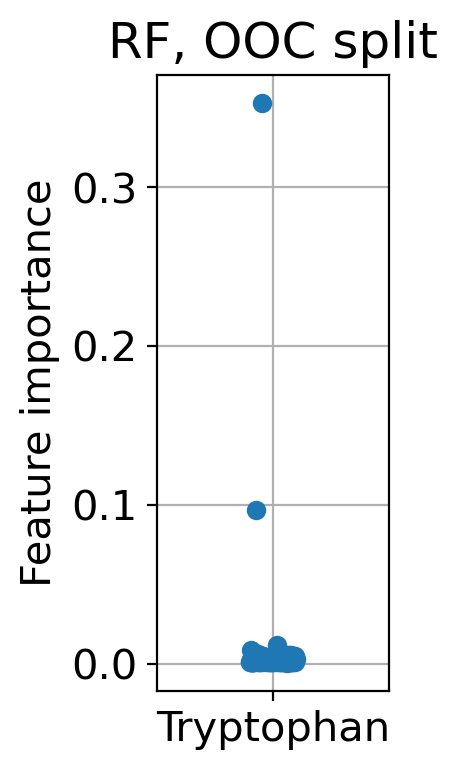

In [22]:
fi=cal_feature_importance(results_all[(results_all['carbon_name']=='tryptophan') & (results_all['model']=='RF_ooc')], bacdive['ko_data'])

fig=plt.figure(figsize=(1.5,4))
sns.stripplot(data=fi, x='carbon_name', y='fi_mean',s=7)

plt.ylabel("Mean feature importance")
plt.xlabel(None)
plt.gca().set_xticklabels(['Tryptophan'])
plt.title("RF, OOC split")
plt.grid()


#### Remove RNF genes from predictors

In [ ]:
threads=48
DIR_figure="/home/zeqianli/project/zeqian/Carbon/data/figure_data/SI/bacdive_rnf"


from scipy.stats import pearsonr
rs={ko: pearsonr(bacdive['ko_data'][ko], bacdive['ko_data']['K03612'])[0] for ko in tqdm(bacdive['ko_data'].columns.values)}
rs=pd.Series(rs).abs().sort_values(ascending=False).iloc[:50]
correlated_genes=rs[rs>0.6].index.values

models={
        'RF_ooc':[RF,
                {'model_params':{'n_estimators':100,'max_depth':None, 'max_features': None},
                'split_method':'ooc',   
                'splitter_params': {'test_set_range':(0.1,0.3), 'min_zeros':0, 'min_ones':0, 'time_out_iter':None},
                'n_splits':100,
                'threads': threads,
                'save_models':True
                }],
        
}

datasets={'bacdive': {'ko_data': bacdive['ko_data'], 'growth_data': bacdive['growth_data'][['tryptophan']],'tree':bacdive['tree'], 'samples':bacdive['samples'],'carbons':['tryptophan']},
          'bacdive_no_rnf': {'ko_data': bacdive['ko_data'].drop(columns=correlated_genes), 'growth_data': bacdive['growth_data'][['tryptophan']],'tree':bacdive['tree'], 'samples':bacdive['samples'],'carbons':['tryptophan']},
         'bacdive_only_tnaA': {'ko_data': bacdive['ko_data'].loc[:,['K01667']], 'growth_data': bacdive['growth_data'][['tryptophan']],'tree':bacdive['tree'], 'samples':bacdive['samples'],'carbons':['tryptophan']}
         }

In [ ]:
p=Pool(threads)

In [ ]:
results_all=run_multiple_models(models, datasets, DIR_figure,
                    p=p)

### Plot

In [20]:
results_all=pd.read_pickle(os.path.join("/home/zeqianli/project/zeqian/Carbon/data/figure_data/SI/bacdive_rnf","results_all.pk"))
results_all_prev=pd.read_pickle("/home/zeqianli/project/zeqian/Carbon/data/figure_data/SI/bacdive/results_all.pk")

df=results_all_prev[(results_all_prev['carbon_name']=='tryptophan') & (results_all_prev['model'].isin(['null_ooc','identity_null_ooc']))]
results_all=pd.concat([results_all, df], axis=0,ignore_index=True)

In [25]:
results_all['model']=results_all['model']+'_'+results_all['dataset_name']

In [26]:
results_all['model'].unique()

array(['RF_ooc_bacdive', 'RF_ooc_bacdive_no_rnf',
       'RF_ooc_bacdive_only_tnaA', 'null_ooc_bacdive',
       'identity_null_ooc_bacdive'], dtype=object)

In [31]:
model_pairs=[('RF_ooc_bacdive', 'RF_ooc_bacdive_no_rnf'), ('RF_ooc_bacdive', 'RF_ooc_bacdive_only_tnaA')]
hue_order=['null_ooc_bacdive',
       'identity_null_ooc_bacdive', 'RF_ooc_bacdive', 'RF_ooc_bacdive_no_rnf',
       'RF_ooc_bacdive_only_tnaA' ]
stats=compare_models(results_all, 
                    model_pairs=[('RF_ooc_bacdive','RF_ooc_bacdive_no_rnf',ttest_permutation),('RF_ooc_bacdive','RF_ooc_bacdive_only_tnaA',ttest_permutation)],
                    seperate_by='carbon_name',
                    model_key='model',
                    metric='accuracy',
                    p_threshold=0.05,
                    multi_testing_correction=False).set_index('carbon_name')

100%|██████████| 1/1 [00:01<00:00,  1.67s/it]


/home/zeqianli/scratch-midway3/miniconda3/envs/zeqian/lib/python3.11/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

tryptophan_RF_ooc_bacdive vs. tryptophan_RF_ooc_bacdive_no_rnf: Custom statistical test, P_val:1.841e-01
tryptophan_RF_ooc_bacdive vs. tryptophan_RF_ooc_bacdive_only_tnaA: Custom statistical test, P_val:1.000e-05


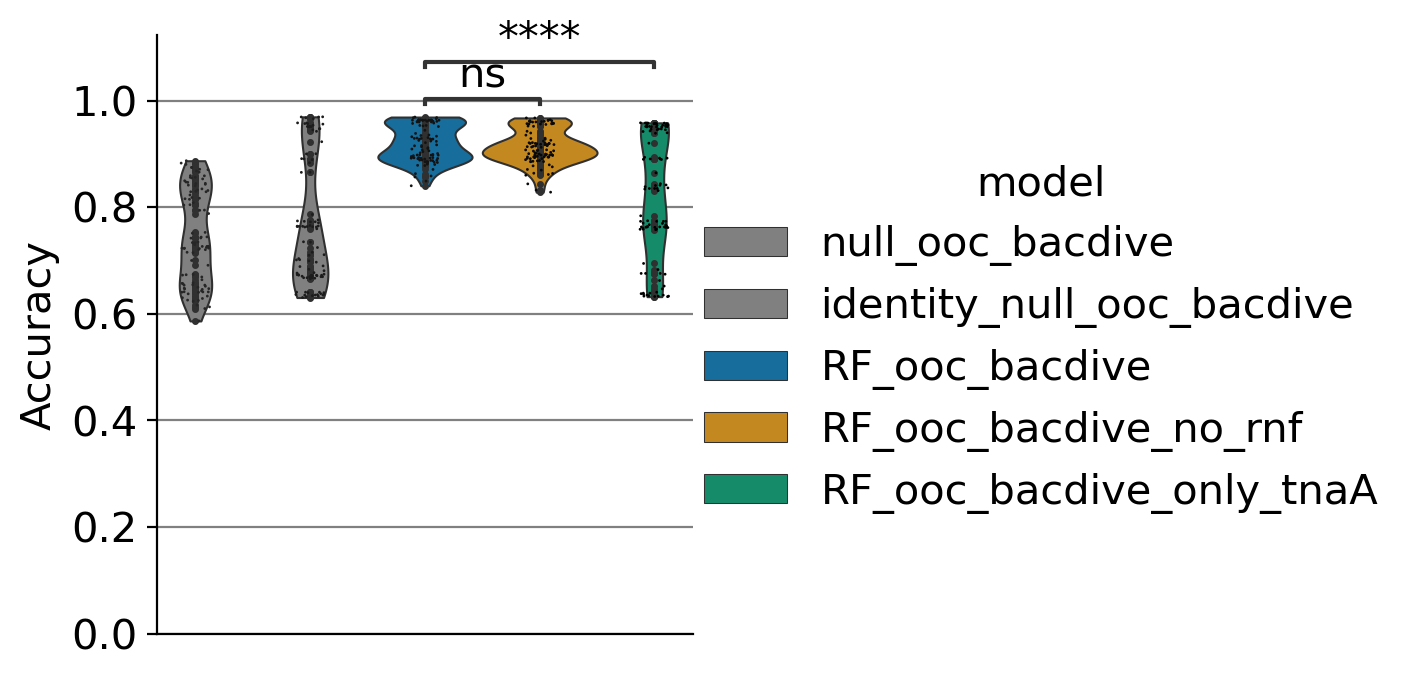

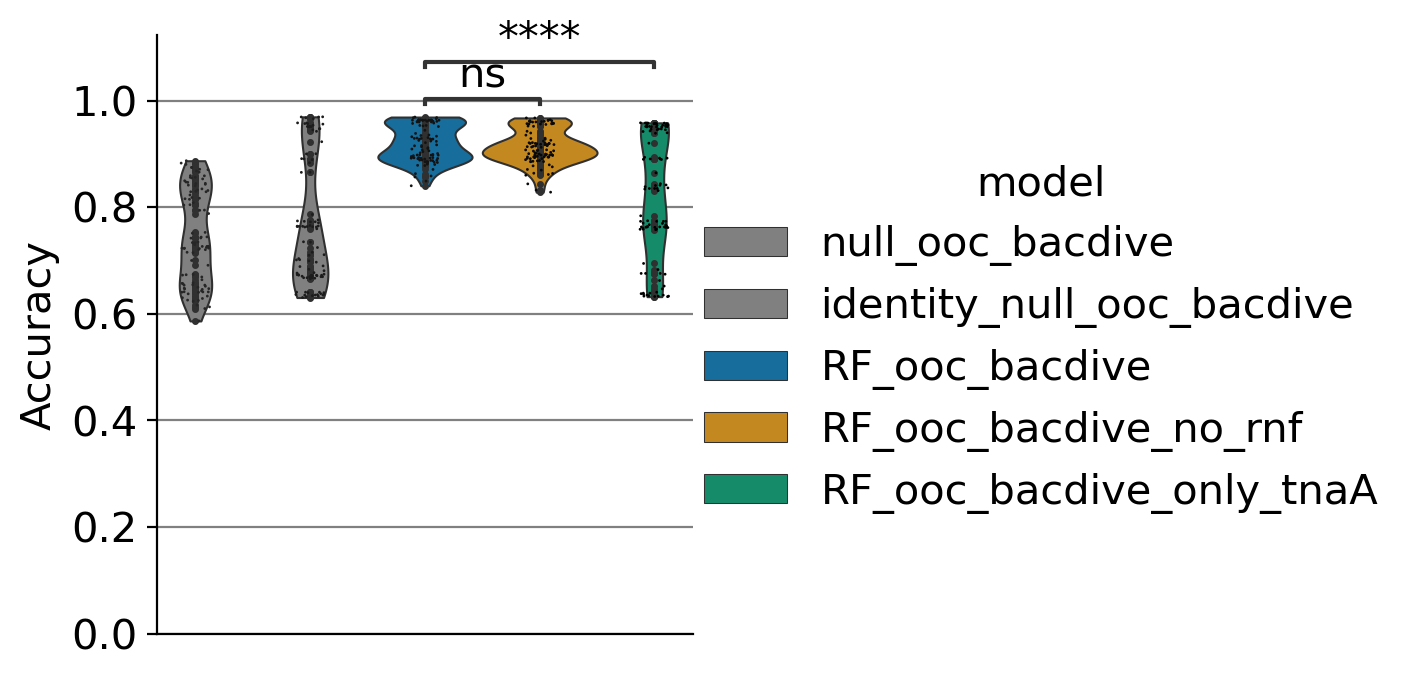

In [42]:

fig, stats=plot_fancy_model_comparison(results_all, hue_order=hue_order,stats=stats, model_pairs=model_pairs, multi_testing_correction=False, height=4, aspect=1.1,rotate_x=False)
#fig.gca().set_title(f"Tryptophan prediction, BacDive dataset")
plt.ylabel('Accuracy')
plt.xlabel(None)

# remove x tick 
plt.gca().set_xticks([])

In [ ]:
fi=cal_feature_importance(results_all[(results_all['dataset_name']=='bacdive_no_rnf')], datasets['bacdive_no_rnf']['ko_data'])

In [ ]:
sns.violinplot(data=results_all, x='dataset_name', y='accuracy',hue='carbon_name')

## Identify strains with improved prediction by using rnfG

In [43]:
def get_strain_accuracy_map(df):
    strain_accuracy={}
    for _, row in tqdm(df.iterrows()):
        X=datasets[row['dataset_name']]['ko_data'].loc[row['test_samples']]
        y_pred=row['_model'].predict(X).astype(int)
        y_data=datasets[row['dataset_name']]['growth_data'].loc[row['test_samples'],row['carbon_name']].astype(int)
        correct_pred=(y_pred==y_data).astype(int)
        for sample, pred in zip(row['test_samples'], correct_pred):
            try:
                strain_accuracy[sample].append(pred)
            except KeyError:
                strain_accuracy[sample]=[pred]
    
    for sample in strain_accuracy:
        strain_accuracy[sample]=np.mean(strain_accuracy[sample])
    
    return pd.Series(strain_accuracy)


In [45]:
results_all

,carbon_name,train_samples,test_samples,feature_importances,true_negative,false_positive,false_negative,true_positive,accuracy,precision,sensitivity,specificity,f1_score,balanced_accuracy,train_sample_size,test_sample_size,_model,model,dataset_name
0,tryptophan,"[10173, 10433, 10434, 10458, 10460, 10461, 104...","[10485, 1120, 11421, 11423, 11467, 11469, 1153...","[0.0, 8.9288705409897e-05, 0.00020122642333978...",240,28,11,23,0.870861,0.450980,0.676471,0.895522,0.541176,0.785996,2092,302,"RF(feature_importances=array([0.00000000e+00, ...",RF_ooc,bacdive
1,tryptophan,"[10173, 10433, 10434, 10458, 10460, 10461, 104...","[11676, 11679, 11680, 11681, 11682, 11683, 116...","[0.0, 0.0, 0.0006888460643026499, 0.0, 0.00018...",206,27,13,103,0.885387,0.792308,0.887931,0.884120,0.837398,0.886026,2045,349,"RF(feature_importances=array([0. , 0. ...",RF_ooc,bacdive
2,tryptophan,"[10173, 10433, 10434, 10458, 10460, 10461, 104...","[11861, 11862, 11865, 11880, 130529, 130530, 1...","[3.780851616997086e-05, 0.0, 0.000203294748540...",237,0,10,2,0.959839,1.000000,0.166667,1.000000,0.285714,0.583333,2145,249,"RF(feature_importances=array([3.78085162e-05, ...",RF_ooc,bacdive
3,tryptophan,"[10173, 10433, 10434, 10458, 10460, 10461, 104...","[11861, 11862, 11865, 11880, 130529, 130530, 1...","[0.0001867167839453078, 7.189332406723709e-05,...",310,1,12,2,0.960000,0.666667,0.142857,0.996785,0.235294,0.569821,2069,325,"RF(feature_importances=array([1.86716784e-04, ...",RF_ooc,bacdive
4,tryptophan,"[10173, 10433, 10434, 10458, 10460, 10461, 104...","[11676, 11679, 11680, 11681, 11682, 11683, 116...","[0.0, 0.0, 0.0006690473649580488, 0.0001097130...",223,26,18,125,0.887755,0.827815,0.874126,0.895582,0.850340,0.884854,2002,392,"RF(feature_importances=array([0. , 0. ...",RF_ooc,bacdive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,tryptophan,"[10173, 10433, 10434, 10458, 10460, 10461, 104...","[11267, 11676, 11679, 11680, 11681, 11682, 116...",[1.0],476,0,148,0,0.762821,NaN,0.000000,1.000000,NaN,0.500000,1770,624,RF(feature_importances=array([1.])),RF_ooc,bacdive_only_tnaA
296,tryptophan,"[10173, 10433, 10434, 10458, 10460, 10461, 104...","[11676, 11679, 11680, 11681, 11682, 11683, 116...",[1.0],260,0,142,0,0.646766,NaN,0.000000,1.000000,NaN,0.500000,1992,402,RF(feature_importances=array([1.])),RF_ooc,bacdive_only_tnaA
297,tryptophan,"[10173, 10433, 10434, 10458, 10460, 10461, 104...","[11861, 11862, 11865, 11880, 130529, 130530, 1...",[1.0],315,3,11,3,0.957831,0.500000,0.214286,0.990566,0.300000,0.602426,2062,332,RF(feature_importances=array([1.])),RF_ooc,bacdive_only_tnaA
298,tryptophan,"[10173, 10433, 10434, 10458, 10460, 10461, 104...","[11267, 11676, 11679, 11680, 11681, 11682, 116...",[1.0],481,0,146,0,0.767145,NaN,0.000000,1.000000,NaN,0.500000,1767,627,RF(feature_importances=array([1.])),RF_ooc,bacdive_only_tnaA


In [52]:
results_all=pd.read_pickle(os.path.join("/home/zeqianli/project/zeqian/Carbon/data/figure_data/SI/bacdive_rnf","results_all.pk"))

datasets={'bacdive': {'ko_data': bacdive['ko_data'], 'growth_data': bacdive['growth_data'][['tryptophan']],'tree':bacdive['tree'], 'samples':bacdive['samples'],'carbons':['tryptophan']},
          # 'bacdive_no_rnf': {'ko_data': bacdive['ko_data'].drop(columns=correlated_genes), 'growth_data': bacdive['growth_data'][['tryptophan']],'tree':bacdive['tree'], 'samples':bacdive['samples'],'carbons':['tryptophan']},
         'bacdive_only_tnaA': {'ko_data': bacdive['ko_data'].loc[:,['K01667']], 'growth_data': bacdive['growth_data'][['tryptophan']],'tree':bacdive['tree'], 'samples':bacdive['samples'],'carbons':['tryptophan']}
         }
accuracy=get_strain_accuracy_map(results_all[results_all['dataset_name']=='bacdive'])
accuracy_only_tnaA=get_strain_accuracy_map(results_all[results_all['dataset_name']=='bacdive_only_tnaA'])
intersect=np.intersect1d(accuracy.index.values, accuracy_only_tnaA.index.values)
better_strains=(accuracy.loc[intersect]-accuracy_only_tnaA.loc[intersect]).sort_values(ascending=False)
better_strains=better_strains[better_strains>0]
with open("/home/zeqianli/project/zeqian/Carbon/data/figure_data/SI/bacdive_rnf/better_strains.pk", 'wb') as f:
    pickle.dump(better_strains, f)

100it [00:05, 17.13it/s]
100it [00:00, 132.48it/s]


In [ ]:
# Display taxa of improved strains
better_strains=pd.read_pickle("/home/zeqianli/project/zeqian/Carbon/data/figure_data/SI/bacdive_rnf/better_strains.pk")
bacdive_16s=pd.read_csv("/home/zeqianli/project/zeqian/Carbon/data/bacdive/bacdive_16S.aligned.csv").set_index('name')
bacdive_16s.index=bacdive_16s.index.str.replace('bacdive_','')
bacdive_16s.loc[better_strains]['lca_tax_slv'].str.split(';', expand=True)

In [ ]:
pred=results_all.apply(get_model_predictions, result_type='expand', axis=1)

In [ ]:
# TODO: where they are on the tree

# Figure 5

## 4A: color KEGG pathways

Use [KEGG Mapper Color](https://www.genome.jp/kegg/mapper/color.html) to plot an example. 

In [ ]:
df=pd.read_pickle("/home/zeqianli/project/zeqian/Carbon/data/kegg/zeqian_kos_by_kegg.pk")

In [ ]:
def generate_kegg_color_texts(df,c, keys=['by_pathway','by_k3_path_directed','by_reaction'],compound_color='red',edge_colors=['yellow','pink','cyan']):
    row=df.loc[c]
    print(f"{row['carbon']}\t{compound_color}")
    colors={}
    for key, edge_color in zip(keys, edge_colors[:len(keys)]):
        for ko in row[key]:
            colors[ko]=edge_color
    
    for ko, c in colors.items():
        print(f"{ko}\t{c}")
    



In [ ]:
generate_kegg_color_texts(df,'Raffinose',keys=['by_k2_path_undirected','by_reaction'])

## 4B. KEGG restricted models

See figure_4B.ipynb

# Archive

## 2A

In [ ]:
# FBA
# The standard pipeline class doesn't work well for this because it checks that the training set and test set must have non-zero samples. Borrow the _pickleable_run_model function. 

fba_paras={c:{'c':c,
              'growth':"/home/zeqianli/project/zeqian/Carbon/data/zeqian/fba_concatenated/zeqian_fba.csv",
              'growth_threshold':0.05} for c in CARBONS}

split_method={c:[growth_data.index.values] for c in CARBONS}
pipe=PredictionPipeline(FBAClassifier,model_params=fba_paras,split_method=split_method,threads=1)
#pipe=PredictionPipeline(FBAClassifier,model_params=fba_paras,split_method='random',splitter_params={'test_set_ratio':0.2},threads=1,n_splits=100)
pipe.generate_splits(ko_data,growth_data)
results=pipe.run()
results['model']='fba'
results_all.append(results)

fba_paras={c:{'c':c,
              'growth':"/home/zeqianli/project/zeqian/Carbon/data/zeqian/fba_concatenated/zeqian_fba_gapfill.csv",
              'growth_threshold':0.05} for c in CARBONS}

split_method={c:[growth_data.index.values] for c in CARBONS}
pipe=PredictionPipeline(FBAClassifier,model_params=fba_paras,split_method=split_method,threads=1)
#pipe=PredictionPipeline(FBAClassifier,model_params=fba_paras,split_method='random',splitter_params={'test_set_ratio':0.2},threads=1,n_splits=100)
pipe.generate_splits(ko_data,growth_data)
results=pipe.run()
results['model']='fba_gapfill'
results_all.append(results)

In [ ]:
# Bernoulli null
pipe=PredictionPipeline(BernoulliNull,split_method='random',splitter_params={'test_set_ratio':0.2},
                        threads=1,n_splits=100)
pipe.generate_splits(ko_data,growth_data)
results_bernoulli=pipe.run()
results_bernoulli['model']='bernoulli'
results_all.append(results_bernoulli)

In [ ]:

# Nearest neighbor, 16S
from genomics_utils import IO
sixteenS_data=IO.read_fasta(f"{DIR_data}/zeqian/zeqian_16S.aligned.fna",df=True)
sixteenS_data=pd.DataFrame([list(s) for s in sixteenS_data.seq],index=sixteenS_data.id)
X=sixteenS_data.replace(['-','A','U','C','G'],[0,1,2,3,4])
X.index=X.index.str.replace('zeqian_','')
X=X.loc[zeqian['samples']]

pipe=PredictionPipeline(NearestNeighbor,model_params={'n_neighbors':1},
                        split_method='random',splitter_params={'test_set_ratio':0.2},
                        n_splits=100,threads=1,p=None)
pipe.generate_splits(X,growth_data)
results=pipe.run()
results['model']='nn_16S'
results_all.append(results)


In [ ]:
# Nearest neighbor, genome

pipe=PredictionPipeline(NearestNeighbor,model_params={'n_neighbors':1},
                        split_method='random',splitter_params={'test_set_ratio':0.2},
                        n_splits=100,threads=1)
pipe.generate_splits(ko_data,growth_data)
results=pipe.run()
results['model']='nn_genome'
results_all.append(results)

# results_all=pd.concat(results_all,axis=0,ignore_index=True)
# results_all.to_pickle("/home/zeqianli/project/zeqianli/Kuehn/Carbon/data/figure_data/2A/models_results.pk")

## 2C

In [ ]:
for model_name, (Model, pipe_params) in models.items():
    for dataset_name,(X,y) in matrices.items():
        try:
            print(f"Running {dataset_name} {model_name}")
            ff_results=os.path.join(DIR_figure,f'{dataset_name}_{model_name}.pk')
            if os.path.exists(ff_results):
                print("Already exists. Skipping. ")
                continue

            pipe=PredictionPipeline(Model,**pipe_params)
            pipe.generate_splits(X,y)
            results=pipe.run()
            with open(ff_results, 'wb') as f:
                pickle.dump(results, f)
        except Exception as e: 
            print(e)
            print(f"Failed to run {dataset_name} {model_name}")


In [ ]:
results_all=[]
for model_name, (Model, pipe_params) in models.items():
    for dataset_name,(X,y) in matrices.items():
        try:
            ff_results=os.path.join(DIR_figure,f'{dataset_name}_{model_name}.pk')
            results=pd.read_pickle(ff_results)
            results['model']=model_name
            results['dataset_name']=dataset_name
            results_all.append(results)
        except Exception as e:
            print(e)
            print(f"Failed to load {dataset_name} {model_name}")

results_all=pd.concat(results_all,axis=0,ignore_index=True)

In [ ]:
results_all.to_pickle(f"{DIR_data}/figure_data/2B/matti_results_all.pk")

In [ ]:
# p-value


results_all=pd.read_pickle(f"{DIR_data}/figure_data/2B/matti_results_all.pk")

stat=compare_models(results_all[results_all['dataset_name']=='matti_16s'], 
                    model_pairs=[
                        # (('fba','null'),one_sample_test),
                        # (('fba_gapfill','null'),one_sample_test),
                        ('NN','null',ttest_permutation),
                        ('NN_ooc','null_ooc',ttest_permutation),
                        ('NN',single_model_summary),
                        ('NN_ooc',single_model_summary),
                    ],
                    seperate_by='carbon_name',
                    model_key='model',
                    metric='accuracy')

stat.to_pickle(f"{DIR_data}/figure_data/2B/matti_stat.pk")

In [ ]:
df=stat[['NN_null_significant','NN_ooc_null_ooc_significant']]


## Matti

In [ ]:
# Bernoulli null
pipe=PredictionPipeline(BernoulliNull,split_method='random',splitter_params={'test_set_ratio':0.2},
                        threads=1,n_splits=100,p=None,carbons=carbons,save_models=False)
pipe.generate_splits(ko_data,growth_data)
results_bernoulli=pipe.run()
results_bernoulli['model']='bernoulli'
results_bernoulli.to_pickle(f"{DIR_data}/figure_data/2B/matti_bernoulli.pk")

# results_all.append(results_bernoulli)

In [ ]:
# Nearest neighbor, genome

pipe=PredictionPipeline(NearestNeighbor,model_params={'n_neighbors':1},
                        split_method='random',splitter_params={'test_set_ratio':0.2},
                        n_splits=100,threads=28,p=p,carbons=carbons,save_models=False)
pipe.generate_splits(ko_data,growth_data)
results=pipe.run()
results['model']='nn_genome'
results.to_pickle(f"{DIR_data}/figure_data/2B/matti_nn_genome.pk")
# results_all.append(results)

# results_all=pd.concat(results_all,axis=0,ignore_index=True)
# results_all.to_pickle("/home/zeqianli/project/zeqianli/Kuehn/Carbon/data/figure_data/2A/models_results.pk")

In [ ]:

# Nearest neighbor, 16S
from genomics_utils import IO
sixteenS_data=IO.read_fasta(f"{DIR_data}/matti/matti_16S.aligned.fna",df=True)
sixteenS_data=pd.DataFrame([list(s) for s in sixteenS_data.seq],index=sixteenS_data.id)
X=sixteenS_data.replace(['-','A','U','C','G'],[0,1,2,3,4])
X.index=X.index.str.replace('matti_','')
X=X.loc[matti['samples']]

pipe=PredictionPipeline(NearestNeighbor,model_params={'n_neighbors':1},
                        split_method='random',splitter_params={'test_set_ratio':0.2},
                        n_splits=100,threads=28,p=p,carbons=carbons,save_models=False)
pipe.generate_splits(X,growth_data)
results=pipe.run()
results['model']='nn_16S'
results.to_pickle(f"{DIR_data}/figure_data/2B/matti_nn_16S.pk")
# results_all.append(results)


In [ ]:
results_all=pd.concat([pd.read_pickle(f"{DIR_data}/figure_data/2B/matti_bernoulli.pk"),
                    pd.read_pickle(f"{DIR_data}/figure_data/2B/matti_nn_genome.pk"),
                    pd.read_pickle(f"{DIR_data}/figure_data/2B/matti_nn_16S.pk")],axis=0,ignore_index=True)
results_all.to_pickle(f"{DIR_data}/figure_data/2B/matti_models_results.pk")

In [ ]:
# Plot
results_all=pd.read_pickle(f"{DIR_data}/figure_data/2B/matti_models_results.pk")
sns.displot(data=results_all, x='accuracy',hue='model',kind='kde',height=6, aspect=1.5,)
#sns.stripplot(data=results_all[results_all['model'].str.contains('fba')], x='carbon_name',y='accuracy',hue='model',legend=False,jitter=False,dodge=True)

ax=plt.gca()
ax.grid()
ax.set_xlim(-0.1,1.1)


In [ ]:
# Option 1
fig=plt.figure(figsize=(5,5))
sns.scatterplot(data=stat, x='NN_null_t',y="NN_ooc_null_ooc_t", hue='NN_null_significant', style='NN_ooc_null_ooc_significant')
# legend on the right outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# draw a line y=x
x=np.linspace(stat['NN_null_t'].min(),stat['NN_null_t'].max(),100)
plt.plot(x,x,'r--')


In [ ]:
# Option 2
fig,axes=plt.subplots(1,2,figsize=(10,5),sharex=True,sharey=True)
sns.scatterplot(data=stat, x='NN_null_t',y="NN_mean", hue='NN_null_significant',ax=axes[0])
sns.scatterplot(data=stat, x='NN_ooc_null_ooc_t',y="NN_ooc_mean", hue='NN_ooc_null_ooc_significant',ax=axes[1])

Another option: x = mean_growth, y=NN_null_t

Also, how to deal with negative t stat? 

TODO: OOC

## Bacdive

In [ ]:
# Run this cell for multithreading. Recycle the same Pool. Do not open multiple pools. 
p=Pool(28)

In [ ]:
ko_data, growth_data, tree,carbons=bacdive['ko_data'],bacdive['growth_data'],bacdive['tree'],bacdive['carbons']

In [ ]:
# Bernoulli null
pipe=PredictionPipeline(BernoulliNull,split_method='random',splitter_params={'test_set_ratio':0.2},
                        threads=1,n_splits=100,p=None,carbons=carbons,save_models=False, 
                       ff_results=f"{DIR_data}/figure_data/2B/cache/bacdive_bernoulli.pk")
pipe.generate_splits(ko_data,growth_data)
results_bernoulli=pipe.run()
results_bernoulli['model']='bernoulli'
results_bernoulli.to_pickle(f"{DIR_data}/figure_data/2B/bacdive_bernoulli.pk")

# results_all.append(results_bernoulli)

In [ ]:
# Nearest neighbor, genome

pipe=PredictionPipeline(NearestNeighbor,model_params={'n_neighbors':1},
                        split_method='random',splitter_params={'test_set_ratio':0.2},
                        n_splits=20,threads=28,p=p,carbons=carbons,save_models=False,
                        ff_results=f"{DIR_data}/figure_data/2B/cache/bacdive_nn_genome.pk")
pipe.generate_splits(ko_data,growth_data)
results=pipe.run()
results['model']='nn_genome'
results.to_pickle(f"{DIR_data}/figure_data/2B/bacdive_nn_genome.pk")
# results_all.append(results)

# results_all=pd.concat(results_all,axis=0,ignore_index=True)
# results_all.to_pickle("/home/zeqianli/project/zeqianli/Kuehn/Carbon/data/figure_data/2A/models_results.pk")

In [ ]:

# Nearest neighbor, 16S
# from genomics_utils import IO
# sixteenS_data=IO.read_fasta(f"{DIR_data}/bacdive/bacdive_16S.aligned.fna",df=True)
# sixteenS_data=pd.DataFrame([list(s) for s in sixteenS_data.seq],index=sixteenS_data.id)
# X=sixteenS_data.replace(['-','A','U','C','G'],[0,1,2,3,4])
# X.index=X.index.str.replace('bacdive_','')
# X=X.loc[bacdive['samples']]

# pipe=PredictionPipeline(NearestNeighbor,model_params={'n_neighbors':1},
#                         split_method='random',splitter_params={'test_set_ratio':0.2},
#                         n_splits=100,threads=28,p=p,carbons=carbons,save_models=False)
# pipe.generate_splits(X,growth_data)
# results=pipe.run()
# results['model']='nn_16S'
# results.to_pickle(f"{DIR_data}/figure_data/2B/bacdive_nn_16S.pk")

# results_all.append(results)


In [ ]:
results_all=pd.concat([pd.read_pickle(f"{DIR_data}/figure_data/2B/bacdive_bernoulli.pk"),
                    pd.read_pickle(f"{DIR_data}/figure_data/2B/bacdive_nn_genome.pk")
                    ],axis=0,ignore_index=True)
results_all.to_pickle(f"{DIR_data}/figure_data/2B/bacdive_models_results.pk")

In [ ]:
results_all=pd.read_pickle(f"{DIR_data}/figure_data/2B/bacdive_models_results.pk")
sns.displot(data=results_all, x='accuracy',hue='model',kind='kde',height=6, aspect=1.5,)
#sns.stripplot(data=results_all[results_all['model'].str.contains('fba')], x='carbon_name',y='accuracy',hue='model',legend=False,jitter=False,dodge=True)

ax=plt.gca()
ax.grid()
ax.set_xlim(-0.1,1.1)
# x axis rotate 90 degree
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90)



In [ ]:
# # Run this cell for testing 

# threads=1

# models={'RF':[RF,None], 'NN': [NearestNeighbor,None], "LogisticRegression":[LassoLogisticRegression,{'C':1.0, 'penalty':'l1','solver':'liblinear'}]}


# split_params={'random': {
#                  'split_method':'random',
#                  'splitter_params': {'test_set_ratio':0.2}, 
#                  'n_splits':2,
#                  'threads': threads,
#                  'save_models':False
#                  },
#         'ooc': {
#                  'split_method':'ooc',
#                  'splitter_params': {'test_set_range':(0.1,0.25), 'min_zeros':0, 'min_ones':0, 'time_out_iter':None}, 
#                  'n_splits':2,
#                  'threads': threads,
#                  'save_models':False
#                  },
#         # 'loo':{
#         #          'split_method':'leave_one_out',
#         #          'splitter_params': {}, 
#         #          'n_splits':2,
#         #          'threads': threads,
#         #          'save_models':False
#         #          }
#         }

##  2A

In [ ]:
for model_name, (Model, pipe_params) in models.items():
    for dataset_name,(X,y) in matrices.items():
        try:
            print(f"Running {dataset_name} {model_name}")
            ff_results=os.path.join(DIR_figure,f'{dataset_name}_{model_name}.pk')
            if os.path.exists(ff_results):
                print("Already exists. Skipping. ")
                continue

            pipe=PredictionPipeline(Model,**pipe_params)
            pipe.generate_splits(X,y)
            results=pipe.run()
            with open(ff_results, 'wb') as f:
                pickle.dump(results, f)
        except Exception as e: 
            print(e)
            print(f"Failed to run {dataset_name} {model_name}")


In [ ]:
results_all=[]
for model_name, (Model, pipe_params) in models.items():
    for dataset_name,(X,y) in matrices.items():
        try:
            ff_results=os.path.join(DIR_figure,f'{dataset_name}_{model_name}.pk')
            results=pd.read_pickle(ff_results)
            results['model']=model_name
            results['dataset_name']=dataset_name
            results_all.append(results)
        except Exception as e:
            print(e)
            print(f"Failed to load {dataset_name} {model_name}")

results_all=pd.concat(results_all,axis=0,ignore_index=True)

In [ ]:
results_all.to_pickle(f"{DIR_data}/figure_data/2A/results_all.pk")

In [ ]:
# p-value

results_all=pd.read_pickle(f"{DIR_data}/figure_data/2A/results_all.pk")
stat=compare_models(results_all[results_all['dataset_name']=='zeqian_16s'], 
                    model_pairs=[
                        ('fba','null',one_sample_test),
                        ('fba_gapfill','null',one_sample_test),
                        ('NN','null',ttest_permutation),
                        ('NN_ooc','null_ooc',ttest_permutation)
                    ],
                    seperate_by='carbon_name',
                    model_key='model',
                    metric='accuracy',
                    p_threshold=0.05,
                    multi_testing_correction=True)

stat.to_pickle(f"{DIR_data}/figure_data/2A/stat.pk")

### Plot

In [ ]:
plt.rcParams['axes.axisbelow'] = True


In [ ]:
results_all=pd.read_pickle(f"{DIR_data}/figure_data/2A/results_all.pk")
stats=pd.read_pickle(f"{DIR_data}/figure_data/2A/stat.pk").set_index('carbon_name')

df=results_all[results_all['dataset_name']=='zeqian_16s']
hue_order=['null','fba','NN','null_ooc','NN_ooc']
df=df[df['model'].isin(hue_order)]

# four color blind friendly colors
colors=['grey','#0072B2','#D55E00', 'grey','#CC79A7'] # ,'#009E73'

sns.catplot(data=df, x='carbon_name',y='accuracy',
            hue='model', hue_order=hue_order, palette=colors,
            kind='violin',height=4, aspect=5,cut=0,linewidth=0.75,inner='box',dodge=True)
#sns.stripplot(data=results_all[results_all['model'].str.contains('fba')], x='carbon_name',y='accuracy',hue='model',legend=False,jitter=False,dodge=True)

ax=plt.gca()
ax.grid()
# ax.grid()

# x axis rotate 90 degree
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# Draw FBA line by wizardry 

half_violin=0.4/len(hue_order)
epsilon=0.03
for i,carbon in enumerate(ax.get_xticklabels()):
    y=df[df['carbon_name']==carbon.get_text()]['accuracy'].values[0]
    x=i-half_violin*(len(hue_order)-3)

    ax.plot([x-half_violin+epsilon,x+half_violin-epsilon],[y,y],color=colors[1],linewidth=2)


In [ ]:

# annotate p-value
from statannotations.Annotator import Annotator

pairs=[]
p_values=[]
model_pairs=[('fba','null'),('NN','null'),('NN_ooc','null_ooc')]
for c in df['carbon_name'].unique():
    for m1,m2 in model_pairs:
        pairs.append(((c,m1),(c,m2)))
        p_values.append(stats.at[c,f'{m1}_{m2}_p'])

annot=Annotator(ax, 
                pairs, 
                data=df,
                x='carbon_name',
                y='accuracy',hue='model',
                hue_order=hue_order)
annot.configure(test=None, comparisons_correction="Bonferroni").set_pvalues(p_values).annotate()

plt.gcf()

## 3A

In [ ]:
for model_name, (Model, pipe_params) in models.items():
    for dataset_name,dataset in matrices.items():
        try:
            print(f"Running {dataset_name} {model_name}")
            ff_cache=os.path.join(DIR_figure,'cache',f'{dataset_name}_{model_name}.pk')
            ff_results=os.path.join(DIR_figure,'results',f'{dataset_name}_{model_name}.pk')
            if os.path.exists(ff_results):
                print("Already exists. Skipping. ")
                continue
            ko_data,growth_data, tree,carbons=dataset['ko_data'],dataset['growth_data'],dataset['tree'],dataset['carbons']
            pipe=PredictionPipeline(Model, tree=tree, carbons=carbons, p=p,  ff_results=ff_cache, **pipe_params)
            pipe.generate_splits(ko_data,growth_data)
            results=pipe.run()
            with open(ff_results, 'wb') as f:
                pickle.dump(results, f)
            print(f"Finished {dataset_name} {model_name} ")
        except Exception as e: 
            print(e)
            print(f"Failed to run {dataset_name} {model_name}")


In [ ]:
results_all=[]
for model_name, (Model, pipe_params) in models.items():
    for dataset_name,dataset in matrices.items():
        try:
            ff_results=os.path.join(DIR_figure,'results',f'{dataset_name}_{model_name}.pk')
            results=pd.read_pickle(ff_results)
            results['model']=model_name
            results['dataset_name']=dataset_name
            results_all.append(results)
        except Exception as e:
            print(e)
            print(f"Failed to load {dataset_name} {model_name}")

results_all=pd.concat(results_all,axis=0,ignore_index=True)
results_all.to_pickle(f"{DIR_data}/figure_data/3A/zeqian_results_all.pk")

In [ ]:
results_all=pd.read_pickle(f"{DIR_data}/figure_data/3A/zeqian_results_all.pk")


In [ ]:
# p-value

results_all=pd.read_pickle(f"{DIR_data}/figure_data/3A/zeqian_results_all.pk")
stat=compare_models(results_all, 
                    model_pairs=[
                        ('NN','null',ttest_permutation),
                        ('NN_ooc','null_ooc',ttest_permutation),
                        ('RF','null',ttest_permutation),
                        ('RF_ooc','null_ooc',ttest_permutation)
                    ],
                    seperate_by='carbon_name',
                    model_key='model',
                    metric='accuracy',
                    p_threshold=0.05,
                    multi_testing_correction=True)

stat.to_pickle(f"{DIR_data}/figure_data/3A/zeqian_stat.pk")

### Plot

In [ ]:
results_all=pd.read_pickle(f"{DIR_data}/figure_data/3A/zeqian_results_all.pk")
stats=pd.read_pickle(f"{DIR_data}/figure_data/3A/zeqian_stat.pk").set_index('carbon_name')

df=results_all
hue_order=['null','RF','NN','null_ooc','RF_ooc','NN_ooc']
df=df[df['model'].isin(hue_order)]

# four color blind friendly colors
colors=['grey','#0072B2','#D55E00', 'grey','#CC79A7','#009E73'] 

sns.catplot(data=df, x='carbon_name',y='accuracy',
            hue='model', hue_order=hue_order, palette=colors,
            kind='violin',height=4, aspect=5,cut=0,linewidth=0.75,inner='box',dodge=True)
#sns.stripplot(data=results_all[results_all['model'].str.contains('fba')], x='carbon_name',y='accuracy',hue='model',legend=False,jitter=False,dodge=True)

ax=plt.gca()
ax.grid()
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# annotate p-value
from statannotations.Annotator import Annotator

pairs=[]
p_values=[]
model_pairs=[('NN','null'),
            ('NN_ooc','null_ooc'),
            ('RF','null'),
            ('RF_ooc','null_ooc')]
for c in df['carbon_name'].unique():
    for m1,m2 in model_pairs:
        pairs.append(((c,m1),(c,m2)))
        p_values.append(stats.at[c,f'{m1}_{m2}_p'])

annot=Annotator(ax, 
                pairs, 
                data=df,
                x='carbon_name',
                y='accuracy',hue='model',
                hue_order=hue_order)
annot.configure(test=None, comparisons_correction="Bonferroni").set_pvalues(p_values).annotate()

plt.gcf()

## BacDive

results_all['carbon_name_sample_number']=results_all['carbon_name']+'_'+(results_all['train_samples'].str.len()+results_all['test_samples'].str.len()).astype(str)
sns.catplot(data=results_all, col='carbon_name_sample_number',x='model',y='balanced_accuracy',kind='violin',cut=0,col_wrap=5,order=['null','NN','RF','null_ooc','NN_ooc','RF_ooc'])
plt.gcf()